<a href="https://colab.research.google.com/github/KumudaBG/Stock-Price-Prediction/blob/main/Generate_model_and_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Package Installation

In [ ]:
!pip install ta

In [ ]:
!pip install shap

In [ ]:
!pip install finta

In [ ]:
!pip install --pre autogluon
!pip install dask[complete]
!pip install --upgrade dask
!pip install mxnet

Requirement already up-to-date: dask in /usr/local/lib/python3.7/dist-packages (2021.3.0)


#Package Imports

In [ ]:
import pandas as pd
import io
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt
import shap as shap
import requests

from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics

from ta.utils import dropna
from ta.volatility import BollingerBands,AverageTrueRange
from ta.momentum import rsi
from ta.momentum import williams_r

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

from matplotlib import pyplot
import io
import seaborn as sns
import numpy as np 

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import f1_score

from io import StringIO
from prettytable import PrettyTable
from matplotlib.colors import ListedColormap
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, precision_recall_curve, recall_score, precision_score, precision_recall_curve, roc_curve, auc

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.kernel_ridge import KernelRidge
#from time import time
import time as time
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split
from datetime import timedelta
from finta import TA
from autogluon.tabular import TabularDataset, TabularPredictor
from joblib import dump, load
    

# Utility Functions

In [ ]:
def kmean_cluster(kdf, max_loop=50):

    try:
        kdf.drop('cluster', axis=1, inplace=True)
    except:
        next
    X = kdf.iloc[:,1:]
    
    rb = RobustScaler()
    X_rb = rb.fit_transform(X)
    
    sse_within_cluster = {}
    silhouette_score = {}
    
    for k in range(2, max_loop):
        kmeans = KMeans(n_clusters=k,  random_state=10, n_init=10, n_jobs=-1)
        kmeans.fit(X_rb)
        sse_within_cluster[k] = kmeans.inertia_
        silhouette_score[k] = metrics.silhouette_score(X_rb, kmeans.labels_, random_state=10)

    _ = plt.figure(figsize=(10,6))
    ax1 = plt.subplot(211)
    _ = plt.plot(list(sse_within_cluster.keys()), list(sse_within_cluster.values()))
    _ = plt.xlabel("Number of Clusters")
    _ = plt.ylabel("SSE Within Cluster")
    _ = plt.title("Within Cluster SSE After K-Means Clustering")
    _ = plt.xticks([i for i in range(2, max_loop)], rotation=75)
    
    ax2 = plt.subplot(212)
    _ = plt.plot(list(silhouette_score.keys()), list(silhouette_score.values()))
    _ = plt.xlabel("Number of Clusters")
    _ = plt.ylabel("Silhouette Score")
    _ = plt.title("Silhouette Score After K-Means Clustering")
    _ = plt.xticks([i for i in range(2, max_loop)], rotation=75)
    
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.35)

In [ ]:
def perform_cluster(aggregated_data, clusters=2):
    
    try:
        aggregated_data.drop('cluster', axis=1, inplace=True)
    except:
        next
    X = aggregated_data.iloc[:,1:]
    rb = RobustScaler()
    X_rb = rb.fit_transform(X)
    kmeans = KMeans(n_clusters=clusters, random_state=10, n_init=10, n_jobs=-1)  
    kmeans.fit(X_rb) 
    score = metrics.silhouette_score(X_rb, kmeans.labels_, random_state=10)
    aggregated_data['cluster'] = kmeans.labels_
    sse_within_cluster = kmeans.inertia_
    
    print("Clustering Performance")
    print("-----------------------------------")
    print("Silhouette score: " + str(score.round(2)))
    print("SSE within cluster: " + str(sse_within_cluster.round()))
    
    return aggregated_data

In [ ]:
def get_sharpe_ratio(df):
    df_w_sharpe_ratio = (
        df
        .pipe(lambda x: x.assign(avg_risk_free_rate=avg_risk_free_rate/100))
        .pipe(lambda x: x.assign(std_dev=np.sqrt(x.variance)))
        .pipe(lambda x: x.assign(sharpe_ratio=(x.avg_yearly_returns-x.avg_risk_free_rate)/x.std_dev))
    )

    return df_w_sharpe_ratio

In [ ]:
def transform_df(df_w_sharpe_ratio):
    df_yearly_returns = (
        df_w_sharpe_ratio
        [['avg_yearly_returns', 'cluster']]
        .pipe(lambda x: x.assign(type='avg_yearly_returns'))
        .rename(columns={"avg_yearly_returns": "rate"})
    )

    df_variance = (
        df_w_sharpe_ratio
        [['variance', 'cluster']]
        .pipe(lambda x: x.assign(type='variance'))
        .rename(columns={"variance": "rate"})
    )

    df_sharpe_ratio = (
        df_w_sharpe_ratio
        [['sharpe_ratio', 'cluster']]
    )

    df_transform = pd.concat([df_yearly_returns, df_variance], axis=0)

    return df_transform, df_sharpe_ratio

In [ ]:
def perf_plot(transform_df, sharpe_ratio_df):
    _  = plt.figure(figsize=(15,7))

    ax1 = plt.subplot(121)
    _ = sns.boxplot(x='cluster', y='rate', hue='type', data=transform_df)
    _ = plt.title("Distribution of Returns and Variance for each Cluster")

    ax2 = plt.subplot(122)
    _ =sns.boxplot(x='cluster', y='sharpe_ratio', data=sharpe_ratio_df, color='royalblue')
    _ = plt.title("Distribution of Sharpe Ratio for each Cluster")

In [ ]:
def select_features(X_train, y_train, X_test):
 fs = SelectKBest(score_func=mutual_info_classif, k='all')
 fs.fit(X_train, y_train)
 X_train_fs = fs.transform(X_train)
 X_test_fs = fs.transform(X_test)
 return X_train_fs, X_test_fs, fs

In [ ]:
def muller_loop_regressor(X_train, y_train, X_test, y_test,type):
 names = [" Decision Tree Regressor",
          "Random Forest", "MLP Regressor",
          "AdaBoost Regressor","Kernel Ridge", "GradientBoostingRegressor","RandomForestRegressor","LinearRegression",
          "LGBMRegressor"]

 regression = [
      DecisionTreeRegressor(max_depth=5),
      RandomForestRegressor(max_depth=5, n_estimators=10),
      MLPRegressor(random_state=1, alpha=1, max_iter=1000),
      AdaBoostRegressor(),
      KernelRidge(alpha=1.0),
      GradientBoostingRegressor(random_state=1),
      RandomForestRegressor(random_state=1),
      LinearRegression(),
      LGBMRegressor(boosting_type='gbdt', objective='regression', num_leaves=1200,
                                learning_rate=0.17,
                                metric='rmse', bagging_fraction=0.8, feature_fraction=0.8, reg_lambda=0.9)
      ]

 max_score = 0.0
 max_class = ''

 result = pd.DataFrame(columns=['MODEL','R2_SCORE','MSE','MAE', 'TIME'])
#iteration
 for name, clf in zip(names, regression):
      print('Model Name:', name)
      start_time = time.time()
      clf.fit(X_train, y_train)
      r2s = 100.0 * clf.score(X_test, y_test)
      y_pred = clf.predict(X_test)
      v_score = 100.0 * explained_variance_score(y_test, y_pred, multioutput='raw_values')[0]
      mse =  mean_squared_error(y_test, y_pred)
      mae =  mean_absolute_error(y_test, y_pred)
      result = result.append({'MODEL': name, 'R2_SCORE': r2s, 'MSE': mse, 'MAE': mae ,'TIME': (time.time() - start_time) }, ignore_index=True)

      if r2s > max_score:
          clf_best = clf
          max_score = r2s
          max_class = name
          y_pred_best = y_pred
 model_name=type+'_'+max_class
 dump(clf_best, model_name) 
 display(result)
 print(clf_best)
 print('Regresssor with better R2 score= %s, Score (test, accuracy) = %.2f' %(max_class, max_score))

In [ ]:
def muller_loop_classifier(classifier_names, classifiers, X, y,executionType):
  result = PrettyTable()
  result.field_names = ["Model", "Accuracy", "F1 Score", "Precision", "Recall"]

  X = StandardScaler().fit_transform(X)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
  max_score = 0.0
  max_class = ''
  # iterate over classifiers
  for name, clf in zip(classifier_names, classifiers):
      start_time = time.time()
      clf.fit(X_train, y_train)
      score = 100.0 * clf.score(X_test, y_test)
      y_pred = clf.predict(X_test)
      f1Score = f1_score(y_test, y_pred, average="macro")
      print('Classifier = %s, Score (test, accuracy) = %.2f,' %(name, score), 'Training time = %.2f seconds' % (time.time() - start_time))
      precision = precision_score(y_test, y_pred, average='macro')
      recall = recall_score(y_test, y_pred, average='macro')
      result.add_row([name, score, f1Score, precision, recall])
      if score > max_score:
          clf_best = clf
          max_score = score
          max_class = name

      labels = clf.predict(X_train)
      # Visualizing the clustering 
      cmap = ListedColormap(['red', 'green', 'blue','yellow'])
      plt.scatter(X_train[:,0], X_train[:,1], c=labels, cmap =cmap) 
      plt.title('Clusters of customers')
      plt.xlabel('Component1')
      plt.ylabel('Component2')
      plt.show()
      print("Confusion Matrix")
      matrix_result = confusion_matrix(y_pred, y_test)
      plot_confusion_matrix(clf, X_test, y_test, display_labels=['0','1','2','3'],cmap=plt.cm.Blues)
      plt.show()
      # draw_confusion_matrix(np.ravel(matrix_result), hv)
  modelName=executionType+"_"+max_class
  dump(clf_best, modelName)
  print(result)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Data Import

Data Set:

1) For initial investigation and analysis we will be using the data from [Kaggle stock Dataset](https://www.kaggle.com/jacksoncrow/stock-market-dataset?select=stocks). This Dataset has around 5800+ stock symbols.

2) We pulled the stock cap details from Nasdaq stock screener [https://www.nasdaq.com/market-activity/stocks/screener].

3) We explored Yahoo finance API for historical stock data and subsided with Kaggle after comparing the output are the same. 

The above google mount is required as the overall stock data is of 2.6GB in size and we are unable to perform web pushish of this data via google sheet. We have placed this data set in our project google drive under the folder [https://drive.google.com/drive/u/1/folders/1SXxkjKv2zRg7ojx7XCqGY6Mwvi1jOlXN]


In [ ]:
#pip install yfinance
#import yfinance as yf

#data_df = yf.download("AAPL", start="2020-02-01", end="2020-03-20")
#data_df.to_csv('aapl.csv')
#data = pd.read_csv('/content/drive/MyDrive/CMPE 257/aapl.csv') 
#data.head()  

Please make sure you have created a short cut to MLSpring-2021 folder in your google drive. This is required to be mounted for the data files to be loaded. 

We could not publish the data onto web using google sheet due to the size of the datasets. 

## Web Scraping

We also scrapped data  from web. Web scraping  lead us  to scrape dividend and technology sector data. We  have the commented code for the same. We have serialized the  file.

In [ ]:
# from bs4 import BeautifulSoup
# import requests

# divArr =[]
# sectorArr = []
# for ticker in golden_cluster1['Ticker'].unique():
#   response = requests.get('https://finance.yahoo.com/quote/'+ticker+'?p='+ticker)
#   soup = BeautifulSoup(response.text, 'html.parser')
#   k = soup.find_all("td", {"class":  "Ta(end) Fw(600) Lh(14px)"})[13].text.split('(')[0]
#   divArr.append(k)

#   try:
#     response = requests.get('https://finance.yahoo.com/quote/'+ticker+'/profile?p='+ticker)
#     soup = BeautifulSoup(response.text, 'html.parser')
#     k = soup.find_all("p", {"class":  "D(ib) Va(t)"})[0]
#     sector_kk = k.find_all("span", {"class": "Fw(600)"})[0].text
#     sectorArr.append(sector_kk)
#   except:
#     sectorArr.append('NA')  

# scrappedDf = pd.DataFrame({'Ticker':golden_cluster1['Ticker'].unique(), 'Div_Val':divArr, 'Sector':sectorArr})
# scrappedDf.to_csv('scrappedData.csv', index=False)
scrappedDf = pd.read_csv('/content/drive/MyDrive/MLSpring-2021/teams/musketeers/Midterm/Data/scrappedData.csv')
scrappedDf.head()


Ticker Div_Val             Sector
0    NOC   5.80         Industrials
1   ANET    N/A          Technology
2   ULTA    N/A   Consumer Cyclical
3   EQIX  11.48         Real Estate
4   FICO    N/A          Technology

In [ ]:
largestock = pd.read_csv('/content/drive/MyDrive/MLSpring-2021/teams/musketeers/Midterm/Stocks Large.csv')

In [ ]:
dfout = pd.read_csv('/content/drive/MyDrive/MLSpring-2021/teams/musketeers/Midterm/Data/out.csv')

We are filtering out the stocks with Large Market Cap [10B and greater] for our future analysis. A total of 854 stocks.

In [ ]:
df = dfout.loc[dfout['Ticker'].isin(largestock['Symbol'])]

In [ ]:
df.head()

Date       Open       High  ...  Adj Close      Volume  Ticker
0  1999-11-18  32.546494  35.765381  ...  27.068665  62546300.0       A
1  1999-11-19  30.713520  30.758226  ...  24.838577  15234100.0       A
2  1999-11-22  29.551144  31.473534  ...  27.068665   6577800.0       A
3  1999-11-23  30.400572  31.205294  ...  24.607880   5975600.0       A
4  1999-11-24  28.701717  29.998211  ...  25.261524   4843200.0       A

[5 rows x 8 columns]

In [ ]:
df.count()

Date         5053096
Open         5052805
High         5052805
Low          5052805
Close        5052805
Adj Close    5052805
Volume       5052805
Ticker       5053096
dtype: int64

In [ ]:
df.Ticker.unique()

array(['A', 'AAL', 'AAP', 'AAPL', 'ABB', 'ABBV', 'ABC', 'ABEV', 'ABMD',
       'ABT', 'ACGL', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE',
       'AEM', 'AEP', 'AES', 'AFL', 'AGCO', 'AGR', 'AIG', 'AJG', 'AKAM',
       'ALB', 'ALC', 'ALGN', 'ALL', 'ALLE', 'ALLY', 'ALNY', 'ALXN',
       'AMAT', 'AMCR', 'AMD', 'AME', 'AMGN', 'AMH', 'AMOV', 'AMP', 'AMT',
       'AMX', 'AMZN', 'ANET', 'ANSS', 'ANTM', 'AON', 'AOS', 'APD', 'APH',
       'APO', 'APPN', 'APTV', 'ARE', 'ARGX', 'ASML', 'ASX', 'ATHM', 'ATO',
       'ATUS', 'ATVI', 'AVB', 'AVGO', 'AVLR', 'AVTR', 'AVY', 'AWK', 'AXP',
       'AZN', 'AZO', 'AZPN', 'BA', 'BABA', 'BAC', 'BAH', 'BAM', 'BAP',
       'BAX', 'BBD', 'BBDO', 'BBIO', 'BBL', 'BBVA', 'BBY', 'BCE', 'BCH',
       'BCS', 'BDX', 'BEN', 'BEP', 'BG', 'BGNE', 'BHC', 'BHP', 'BIDU',
       'BIIB', 'BILI', 'BILL', 'BIO', 'BIP', 'BK', 'BKI', 'BKNG', 'BKR',
       'BLK', 'BLL', 'BMO', 'BMRN', 'BMY', 'BNS', 'BNTX', 'BP', 'BPY',
       'BR', 'BRO', 'BSAC', 'BSBR', 'BSX', 'BTI', 'BUD', '

In [ ]:
df['Year'] = pd.DatetimeIndex(df['Date']).year
df.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Date       Open       High  ...      Volume  Ticker  Year
0  1999-11-18  32.546494  35.765381  ...  62546300.0       A  1999
1  1999-11-19  30.713520  30.758226  ...  15234100.0       A  1999
2  1999-11-22  29.551144  31.473534  ...   6577800.0       A  1999
3  1999-11-23  30.400572  31.205294  ...   5975600.0       A  1999
4  1999-11-24  28.701717  29.998211  ...   4843200.0       A  1999

[5 rows x 9 columns]

In [ ]:
df.Year.unique()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5053096 entries, 0 to 24165053
Data columns (total 9 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Date       object 
 1   Open       float64
 2   High       float64
 3   Low        float64
 4   Close      float64
 5   Adj Close  float64
 6   Volume     float64
 7   Ticker     object 
 8   Year       int64  
dtypes: float64(6), int64(1), object(2)
memory usage: 385.5+ MB


# Data Manipulation/Processing

As we are having a large amount of data. We will like to narrow our datat to 7 years i.e 2014-2020. This narrowing down of data will help us in analyzing the stocks wheere we are investing better.

In [ ]:
#  Taking a subset of data from year 2014-2020

df1 = df[df.Year.isin([2014,2015,2016,2017,2018,2019,2020])]

In [ ]:
# Inspecting the records
df1.head()

Date       Open       High  ...     Volume  Ticker  Year
3551  2014-01-02  40.844063  40.844063  ...  2678800.0       A  2014
3552  2014-01-03  40.336193  41.022888  ...  2609600.0       A  2014
3553  2014-01-06  41.058655  41.273247  ...  2484600.0       A  2014
3554  2014-01-07  40.736767  41.223175  ...  2045500.0       A  2014
3555  2014-01-08  41.008583  41.874107  ...  3717900.0       A  2014

[5 rows x 9 columns]

In [ ]:
#  Inspecting the Data Type

df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1196565 entries, 3551 to 24165053
Data columns (total 9 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   Date       1196565 non-null  object 
 1   Open       1196488 non-null  float64
 2   High       1196488 non-null  float64
 3   Low        1196488 non-null  float64
 4   Close      1196488 non-null  float64
 5   Adj Close  1196488 non-null  float64
 6   Volume     1196488 non-null  float64
 7   Ticker     1196565 non-null  object 
 8   Year       1196565 non-null  int64  
dtypes: float64(6), int64(1), object(2)
memory usage: 91.3+ MB


##  Feature Engineering

In this section we will be deriving certain features that will help us in  further  analyzing the stock market  data

In [ ]:
# Getting the first day and last day of each year that is available in the data 

first_date_list = [df1.query("Year == '{}'".format(2014+i)).Date.min() for i in range(5)]
last_date_list = [df1.query("Year == '{}'".format(2014+i)).Date.max() for i in range(5)]
first_date_df =pd.DataFrame({"Date": first_date_list}) 
last_date_df = pd.DataFrame({"Date": last_date_list})

In [ ]:
# Inspecting the first and last day of the year.       
print(first_date_df)
print(last_date_df)

         Date
0  2014-01-02
1  2015-01-02
2  2016-01-04
3  2017-01-02
4  2018-01-01
         Date
0  2014-12-31
1  2015-12-31
2  2016-12-30
3  2017-12-29
4  2018-12-31


## Filtering first day data

We will  be filtering the  first day  data for each stock. This gives us the start of market open and close on the first day.

In [ ]:
agg_first_date_df = (
    df1
    .merge(first_date_df, on='Date', how='inner')
    .pipe(lambda x: x.assign(Year=x.Date.str[:4]))
    .rename(columns={"Open": "open_first_day", "Close": "close_first_day"})
    .reset_index(drop=True)
    [['Ticker', 'Year', 'open_first_day', 'close_first_day']]
)

In [ ]:
# Inspecting the dataframe's data types
agg_first_date_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2184 entries, 0 to 2183
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Ticker           2184 non-null   object 
 1   Year             2184 non-null   object 
 2   open_first_day   2182 non-null   float64
 3   close_first_day  2182 non-null   float64
dtypes: float64(2), object(2)
memory usage: 68.4+ KB


In [ ]:
# Inspecting the dataframe
agg_first_date_df.head()

Ticker  Year  open_first_day  close_first_day
0      A  2014       40.844063        40.207439
1    AAL  2014       25.070000        25.360001
2    AAP  2014      110.360001       109.739998
3   AAPL  2014       79.382858        79.018570
4    ABB  2014       26.170000        25.930000

## Filtering Last day data

We will  be filtering the  last day  data for each stock. This gives us the start of market open and close on the last day  of  the year.

In [ ]:
agg_last_date_df = (
    df1
    .merge(last_date_df, on='Date', how='inner')
    .pipe(lambda x: x.assign(Year=x.Date.str[:4]))
    .rename(columns={"Open": "open_last_day", "Close": "close_last_day"})
    .reset_index(drop=True)
    [['Ticker', 'Year', 'open_last_day', 'close_last_day']]
)

In [ ]:
# Inspecting the dataframe's data types
agg_last_date_df.info

<bound method DataFrame.info of      Ticker  Year  open_last_day  close_last_day
0         A  2014      41.389999       40.939999
1       AAL  2014      53.900002       53.630001
2       AAP  2014     160.639999      159.279999
3      AAPL  2014     112.820000      110.379997
4       ABB  2014      21.440001       21.150000
...     ...   ...            ...             ...
3786   ZNGA  2018       3.900000        3.930000
3787    ZNH  2018      30.770000       30.360001
3788     ZS  2018      40.240002       39.209999
3789    ZTO  2018      16.000000       15.830000
3790    ZTS  2018      85.269997       85.540001

[3791 rows x 4 columns]>

In [ ]:
# Inspecting the dataframe
agg_last_date_df.head()

Ticker  Year  open_last_day  close_last_day
0      A  2014      41.389999       40.939999
1    AAL  2014      53.900002       53.630001
2    AAP  2014     160.639999      159.279999
3   AAPL  2014     112.820000      110.379997
4    ABB  2014      21.440001       21.150000

## Yearly return and average yearly return

Now we will go  ahead and calculate  a new   feature called  yearly returns and then calculate the average  yearly returns.

In [ ]:
# calculating yearly return and then averaging them to get average yearly returns for each stock
agg_gains_df = (
    agg_first_date_df
    .merge(agg_last_date_df, on=['Ticker', 'Year'], how='left')
    .pipe(lambda x: x.assign(gains_dollar=x.close_last_day-x.open_first_day))
    .pipe(lambda x: x.assign(gains_pctg=x.gains_dollar/x.open_first_day))
    .groupby("Ticker")
    .agg({"gains_pctg": "mean"})
    .reset_index()
    .rename(columns={"gains_pctg": "avg_yearly_returns"})
)

In [ ]:
# Inspecting the dataframe's data types
agg_gains_df.info

<bound method DataFrame.info of     Ticker  avg_yearly_returns
0        A            0.042414
1      AAL            0.350069
2      AAP            0.170708
3     AAPL            0.154728
4      ABB           -0.048230
..     ...                 ...
744    ZEN           -0.050699
745     ZG            0.162910
746   ZNGA           -0.111308
747    ZNH            0.189617
748    ZTS            0.188598

[749 rows x 2 columns]>

In [ ]:
# Inspecting the dataframe
agg_gains_df.head()

Ticker  avg_yearly_returns
0      A            0.042414
1    AAL            0.350069
2    AAP            0.170708
3   AAPL            0.154728
4    ABB           -0.048230

## Calculating overall variance using each year return

Calculating the varience for each  stock  using the year's  returns. This will  help us in analyzing  the risk.

In [ ]:
# calculating overall variance using each year's return
agg_var_df = (
    agg_first_date_df
    .merge(agg_last_date_df, on=['Ticker', 'Year'], how='left')
    .pipe(lambda x: x.assign(gains_dollar=x.close_last_day-x.open_first_day))
    .pipe(lambda x: x.assign(gains_pctg=x.gains_dollar/x.open_first_day))
    [['Ticker', 'gains_pctg']]
    .groupby("Ticker")
    .agg(np.var)
    .reset_index()
    .rename(columns={"gains_pctg": "variance"})
)

In [ ]:
# Inspecting the dataframe's data types
agg_var_df.info

<bound method DataFrame.info of     Ticker  variance
0        A  0.003427
1      AAL  0.497783
2      AAP  0.065463
3     AAPL  0.050126
4      ABB  0.049789
..     ...       ...
744    ZEN  0.035365
745     ZG  0.109458
746   ZNGA  0.026795
747    ZNH  0.202444
748    ZTS  0.013860

[749 rows x 2 columns]>

In [ ]:
# Merging the dataframe
agg_df3 = (
    agg_gains_df
    .merge(agg_var_df, on='Ticker', how='inner')
)

In [ ]:
# Inspecting the dataframe's data types
agg_df3.info

<bound method DataFrame.info of     Ticker  avg_yearly_returns  variance
0        A            0.042414  0.003427
1      AAL            0.350069  0.497783
2      AAP            0.170708  0.065463
3     AAPL            0.154728  0.050126
4      ABB           -0.048230  0.049789
..     ...                 ...       ...
744    ZEN           -0.050699  0.035365
745     ZG            0.162910  0.109458
746   ZNGA           -0.111308  0.026795
747    ZNH            0.189617  0.202444
748    ZTS            0.188598  0.013860

[749 rows x 3 columns]>

In [ ]:
# Inspecting the dataframe
agg_df3.head()

Ticker  avg_yearly_returns  variance
0      A            0.042414  0.003427
1    AAL            0.350069  0.497783
2    AAP            0.170708  0.065463
3   AAPL            0.154728  0.050126
4    ABB           -0.048230  0.049789

In [ ]:
agg_df3.isnull()

Ticker  avg_yearly_returns  variance
0     False               False     False
1     False               False     False
2     False               False     False
3     False               False     False
4     False               False     False
..      ...                 ...       ...
744   False               False     False
745   False               False     False
746   False               False     False
747   False               False     False
748   False               False     False

[749 rows x 3 columns]

In [ ]:
agg_df3.isnull().any(axis=1)

0      False
1      False
2      False
3      False
4      False
       ...  
744    False
745    False
746    False
747    False
748    False
Length: 749, dtype: bool

In [ ]:
agg_df3[agg_df3.isnull().any(axis=1)]

Ticker  avg_yearly_returns  variance
23     AGR           -0.023208       NaN
92    BILL                 NaN       NaN
96     BKI            0.159865       NaN
119   CABO            0.451216       NaN
250   ETSY            0.440098       NaN
286   GDDY            0.102176       NaN
323    HPE            0.545758       NaN
352   INVH            0.000000       NaN
379    KHC            0.223312       NaN
460   MTCH            0.273269       NaN
484    NTR                 NaN       NaN
489   NVCR           -0.643182       NaN
547   PYPL            0.123541       NaN
552   RACE            0.229435       NaN
581   SEDG           -0.520866       NaN
584   SHOP            0.686467       NaN
605     SQ            0.069020       NaN
628   TDOC           -0.066214       NaN
630   TEAM           -0.167934       NaN
653    TRU            0.137132       NaN
727    WRK            0.257523       NaN
741      Z            0.580156       NaN

In [ ]:
agg_df3.info

<bound method DataFrame.info of     Ticker  avg_yearly_returns  variance
0        A            0.042414  0.003427
1      AAL            0.350069  0.497783
2      AAP            0.170708  0.065463
3     AAPL            0.154728  0.050126
4      ABB           -0.048230  0.049789
..     ...                 ...       ...
744    ZEN           -0.050699  0.035365
745     ZG            0.162910  0.109458
746   ZNGA           -0.111308  0.026795
747    ZNH            0.189617  0.202444
748    ZTS            0.188598  0.013860

[749 rows x 3 columns]>

In [ ]:
agg_df3 = agg_df3.dropna()

In [ ]:
agg_df3.info

<bound method DataFrame.info of     Ticker  avg_yearly_returns  variance
0        A            0.042414  0.003427
1      AAL            0.350069  0.497783
2      AAP            0.170708  0.065463
3     AAPL            0.154728  0.050126
4      ABB           -0.048230  0.049789
..     ...                 ...       ...
744    ZEN           -0.050699  0.035365
745     ZG            0.162910  0.109458
746   ZNGA           -0.111308  0.026795
747    ZNH            0.189617  0.202444
748    ZTS            0.188598  0.013860

[727 rows x 3 columns]>

#KMeans and Silhouette scores for generating the Golden Cluster

##First Iteration

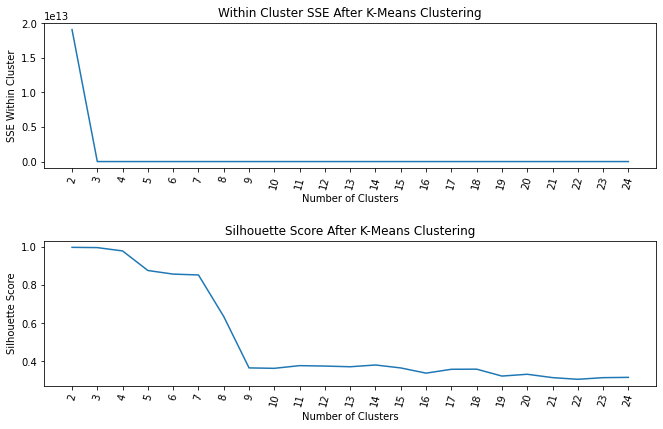

In [ ]:
kmean_cluster(agg_df3, max_loop=25)

In [ ]:
first_trial = perform_cluster(agg_df3, clusters=9)

Clustering Performance
-----------------------------------
Silhouette score: 0.37
SSE within cluster: 1039.0



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
cluster_perf_df = (
    first_trial
    .groupby('cluster')
    .agg({"avg_yearly_returns":"mean", "variance":"mean", "Ticker":"count"})
    .sort_values('avg_yearly_returns')
    .reset_index()
)

cluster_perf_df

cluster  avg_yearly_returns      variance  Ticker
0        8           -0.033589  4.196546e-02     239
1        4            0.152626  3.768478e-02     382
2        0            0.168715  2.667883e-01      86
3        6            0.360543  1.028270e+00      15
4        5            0.954092  3.470331e+00       1
5        7            1.095199  8.570510e+00       1
6        3            1.115771  1.131548e+01       1
7        2          391.568939  3.074813e+05       1
8        1        30833.265589  2.851997e+09       1

In [ ]:
agg_df3_sub = agg_df3.query("cluster == 4").reset_index(drop=True)

##Second Iteration

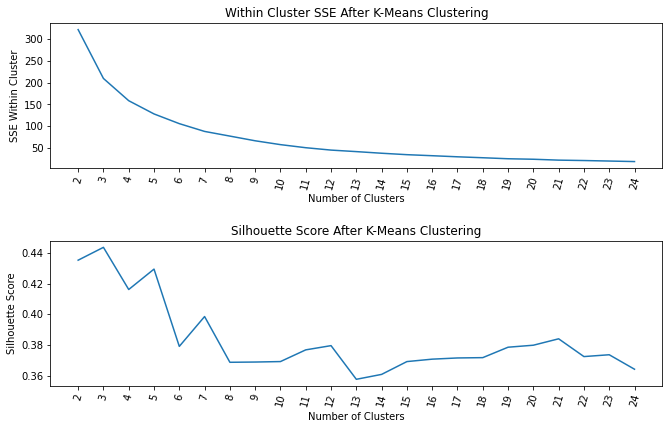

In [ ]:
kmean_cluster(agg_df3_sub, max_loop=25)

In [ ]:
second_trial= perform_cluster(agg_df3_sub, clusters=3)

Clustering Performance
-----------------------------------
Silhouette score: 0.44
SSE within cluster: 209.0


In [ ]:
sub_cluster_perf_df = (
    second_trial
    .groupby('cluster')
    .agg({"avg_yearly_returns":"mean", "variance":"mean", "Ticker":"count"})
    .sort_values('avg_yearly_returns')
    .reset_index()
)

sub_cluster_perf_df

cluster  avg_yearly_returns  variance  Ticker
0        1            0.125685  0.018287     233
1        0            0.129679  0.084229      89
2        2            0.291284  0.043972      60

In [ ]:
us_yield_curve_5years_dict = {"year": [2014, 2015, 2016, 2017, 2018,2019,2020],
                         "risk_free_rate": [1.72, 1.61, 1.73, 1.94, 2.25, 2.48, 1.67]}
us_yield_curve_5years_df = pd.DataFrame.from_dict(us_yield_curve_5years_dict)

In [ ]:
avg_risk_free_rate = (
    us_yield_curve_5years_df
    .mean()
    [['risk_free_rate']]
    [0]
)

In [ ]:
second_trial_w_sharpe_ratio = get_sharpe_ratio(second_trial)

In [ ]:
sub_cluster_transform, sub_cluster_sharpe_ratio = transform_df(second_trial_w_sharpe_ratio)

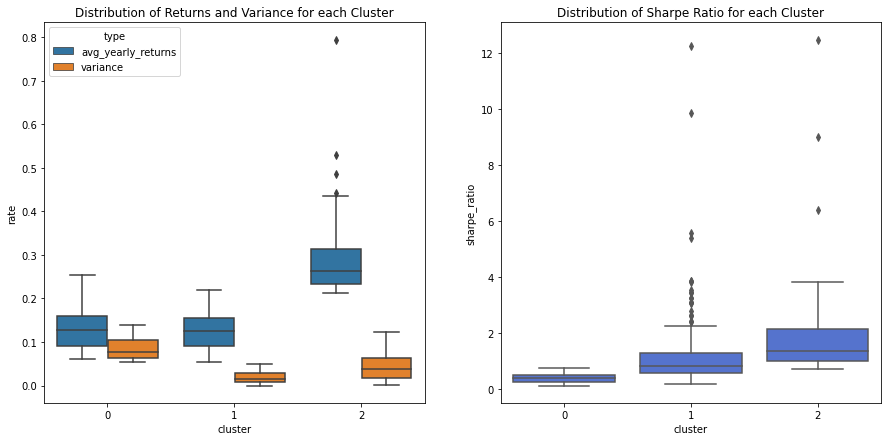

In [ ]:
perf_plot(sub_cluster_transform, sub_cluster_sharpe_ratio)

In [ ]:
best_sub_cluster = second_trial.query("cluster == 2")

##Third Iteration


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


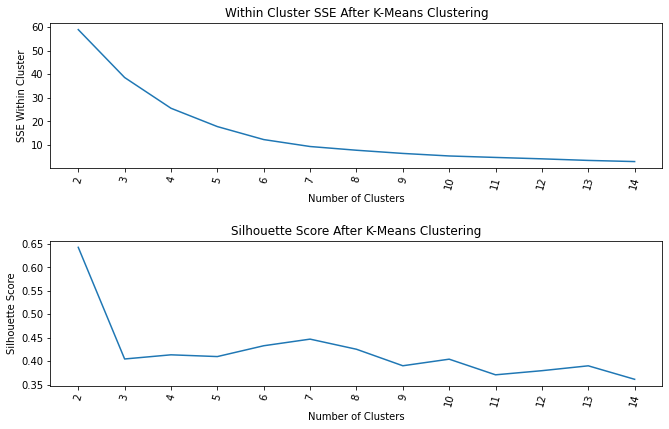

In [ ]:
kmean_cluster(best_sub_cluster, max_loop=15)

In [ ]:
third_trial = perform_cluster(best_sub_cluster, clusters=3)

Clustering Performance
-----------------------------------
Silhouette score: 0.4
SSE within cluster: 39.0



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
best_sub_cluster_perf = (    
    third_trial
    .groupby('cluster')
    .agg({"avg_yearly_returns":"mean", "variance":"mean", "Ticker":"count"})
    .sort_values('avg_yearly_returns')
    .reset_index()
)
best_sub_cluster_perf

cluster  avg_yearly_returns  variance  Ticker
0        0            0.267078  0.020731      34
1        2            0.271855  0.076171      21
2        1            0.537486  0.066784       5

In [ ]:
best_sub_cluster1 = third_trial.query("cluster == 1")

In [ ]:
third_trial_w_sharpe_ratio = get_sharpe_ratio(third_trial)

In [ ]:
best_sub_cluster_transform, best_sub_cluster_sharpe_ratio = transform_df(third_trial_w_sharpe_ratio)

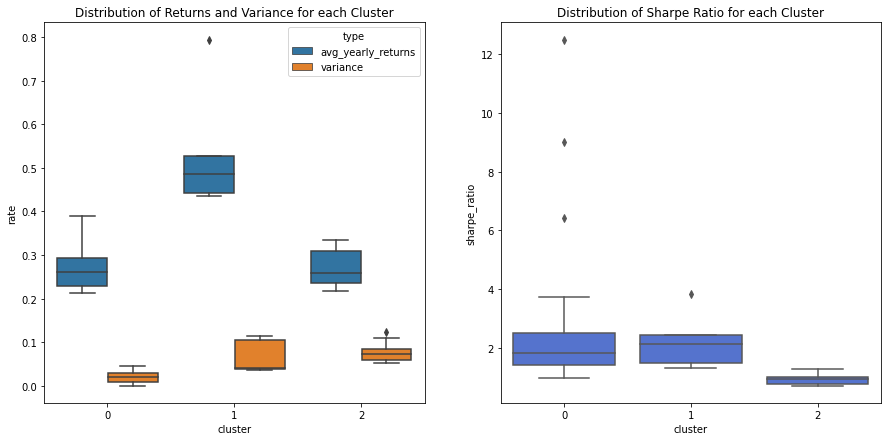

In [ ]:
perf_plot(best_sub_cluster_transform, best_sub_cluster_sharpe_ratio)

From the above Fractal clustering we have gotten out Golden Cluster in the second iteration - "best_sub_cluster"

In [ ]:
best_sub_cluster.describe()

avg_yearly_returns   variance    cluster
count           60.000000  60.000000  60.000000
mean             0.291284   0.043972   0.783333
std              0.093531   0.032750   0.940459
min              0.213448   0.000408   0.000000
25%              0.233609   0.017902   0.000000
50%              0.263386   0.037135   0.000000
75%              0.314660   0.062280   2.000000
max              0.794780   0.122454   2.000000

# Data Visualization and  Analysis
In this section we analyse  the various technical indicator and  try  to  derive various inferences.

In [ ]:
# Inspecting the Golden Cluster and Sorting it by varience
golden_cluster1 = best_sub_cluster
golden_cluster1 = golden_cluster1.sort_values(by="variance", ascending=True, axis=0)
golden_cluster1.head()

Ticker  avg_yearly_returns  variance  cluster
254    NOC            0.271557  0.000408        0
22    ANET            0.262069  0.000725        0
352   ULTA            0.389413  0.003340        0
119   EQIX            0.264044  0.004405        0
136   FICO            0.243818  0.005752        0

##  Calculating sharpe ratio for the various stocks in our Golden Cluster

In [ ]:
golden_cluster1[['avg_risk_free_rate',	'std_dev',	'sharpe_ratio']] = get_sharpe_ratio(golden_cluster1)[['avg_risk_free_rate',	'std_dev',	'sharpe_ratio']]
golden_cluster1.head()

Ticker  avg_yearly_returns  ...   std_dev  sharpe_ratio
254    NOC            0.271557  ...  0.020199     12.496238
22    ANET            0.262069  ...  0.026923      9.023071
352   ULTA            0.389413  ...  0.057795      6.406656
119   EQIX            0.264044  ...  0.066368      3.690034
136   FICO            0.243818  ...  0.075840      2.962507

[5 rows x 7 columns]

Lets shortlist top 8 stocks from the Golden Cluster and then see the market trends. We  picked  these by sorting the sharpe ratio in  descending order.

In [ ]:
golden_cluster1 = golden_cluster1.sort_values(by=['sharpe_ratio'], ascending=False)
golden_cluster1.head()

Ticker  avg_yearly_returns  ...   std_dev  sharpe_ratio
254    NOC            0.271557  ...  0.020199     12.496238
22    ANET            0.262069  ...  0.026923      9.023071
352   ULTA            0.389413  ...  0.057795      6.406656
140   FIVN            0.794780  ...  0.202033      3.839151
239   MPWR            0.343613  ...  0.087135      3.723772

[5 rows x 7 columns]

## Visualizing Sharpe  Ratio  for   each stock

Now  we  will be visualizing  the sharpe  ratio for each  stock.  This will  help us  select  some of the stocks with which  we would  like to  deal  with.

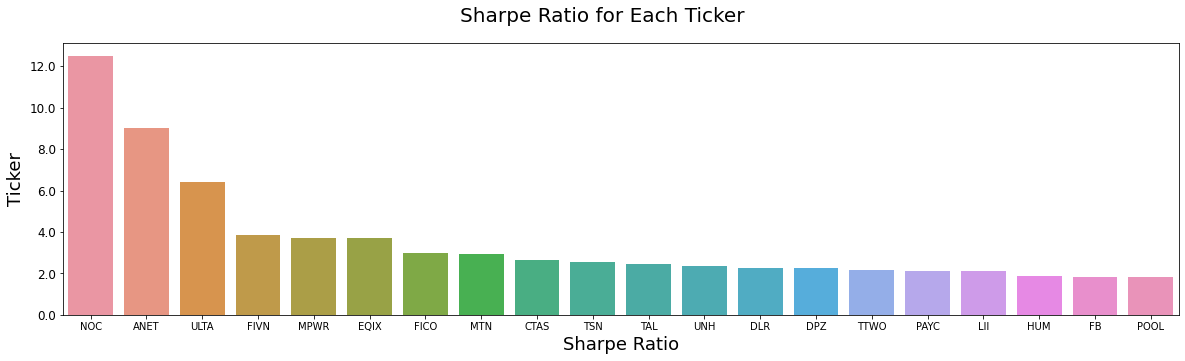

In [ ]:
# Bar Graph with  sharpe Ratio
plt.figure(figsize=(20,5))
plt.suptitle('Sharpe Ratio for Each Ticker', fontsize=20)
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
ax = sns.barplot(data=golden_cluster1[:20], x="Ticker", y="sharpe_ratio")
ax.set(xlabel='Sharpe Ratio', ylabel='Ticker')
ax.set_yticklabels(ax.get_yticks(), size = 12)
plt.show()

Lets select these Values in order to see the stocks that we would require to add to out portfolio. With the Sharpe Ratio we can see that the stocks above 1 will  be  performing   really well in  our  portfolio. We  will be  using  the  top 8 stocks for the same.

In [ ]:
# Getting the list of  tickers
tickersDf = golden_cluster1['Ticker'][:8]

# Extracting  the values from the Ticker Values as we got above.
newDf = df1[df1['Ticker'].isin(tickersDf)]

# RSI  Calc
def computeRSI (data, time_window):
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    
    # check pandas documentation for ewm
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    # values are related to exponential decay
    # we set com=time_window-1 so we get decay alpha=1/time_window
    up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi

newDf['RSI'] = computeRSI(newDf.groupby('Ticker')['Adj Close'], 14)

newDf.set_index('Date',inplace=True)

# Checking whether we got the correct Tickers
newDf['Ticker'].unique()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


array(['ANET', 'EQIX', 'FICO', 'FIVN', 'MPWR', 'MTN', 'NOC', 'ULTA'],
      dtype=object)

In [ ]:
newDf.head(20)

Open       High        Low  ...  Ticker  Year        RSI
Date                                         ...                         
2014-06-06  55.250000  60.000000  55.000000  ...    ANET  2014        NaN
2014-06-09  56.250000  57.000000  55.000000  ...    ANET  2014        NaN
2014-06-10  55.250000  60.000000  55.250000  ...    ANET  2014        NaN
2014-06-11  60.000000  63.500000  58.660000  ...    ANET  2014        NaN
2014-06-12  63.650002  67.830002  63.070000  ...    ANET  2014        NaN
2014-06-13  68.470001  72.000000  67.000000  ...    ANET  2014        NaN
2014-06-16  71.220001  71.500000  67.635002  ...    ANET  2014        NaN
2014-06-17  71.889999  72.629997  69.000000  ...    ANET  2014        NaN
2014-06-18  70.070000  71.000000  67.879997  ...    ANET  2014        NaN
2014-06-19  68.029999  68.809998  64.510002  ...    ANET  2014        NaN
2014-06-20  65.050003  68.500000  64.500000  ...    ANET  2014        NaN
2014-06-23  65.019997  67.489998  65.019997  ...    ANET  2014        NaN
2014-06-24  66.349998  66.750000  63.869999  ...    ANET  2014        NaN
2014-06-25  63.810001  65.358002  62.000000  ...    ANET  2014        NaN
2014-06-26  64.809998  64.809998  62.500000  ...    ANET  2014  57.662331
2014-06-27  63.910000  63.910000  62.250000  ...    ANET  2014  52.711944
2014-06-30  62.070000  65.199997  62.070000  ...    ANET  2014  52.100270
2014-07-01  66.970001  76.830002  66.099998  ...    ANET  2014  76.781541
2014-07-02  78.739998  80.529999  73.199997  ...    ANET  2014  74.799227
2014-07-03  76.440002  77.626999  74.099998  ...    ANET  2014  75.892301

[20 rows x 9 columns]

##  Extract the  daily change and  see the trends of the  8 stocks presented

In [ ]:
# We will calculate the daily change for the stocks
newDf['Daily_Change'] = newDf.groupby('Ticker')['Adj Close'].pct_change()
newDf.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Open       High    Low  ...  Year  RSI  Daily_Change
Date                                     ...                         
2014-06-06  55.250000  60.000000  55.00  ...  2014  NaN           NaN
2014-06-09  56.250000  57.000000  55.00  ...  2014  NaN      0.003636
2014-06-10  55.250000  60.000000  55.25  ...  2014  NaN      0.086957
2014-06-11  60.000000  63.500000  58.66  ...  2014  NaN      0.058333
2014-06-12  63.650002  67.830002  63.07  ...  2014  NaN      0.039370

[5 rows x 10 columns]

The above number of 8  proves that we have calculated the Daily Change correctly. As the first value of each of the column will be NaN.

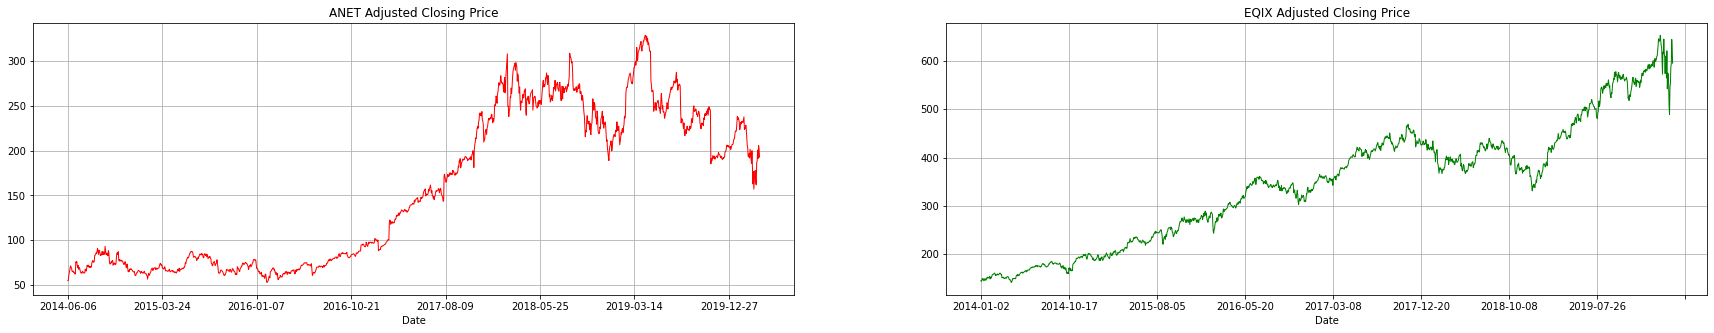

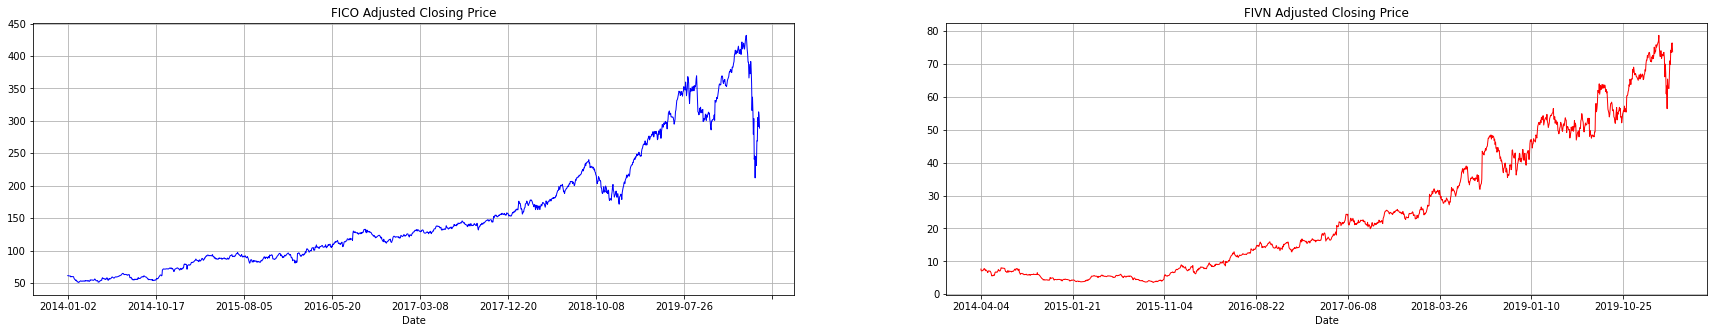

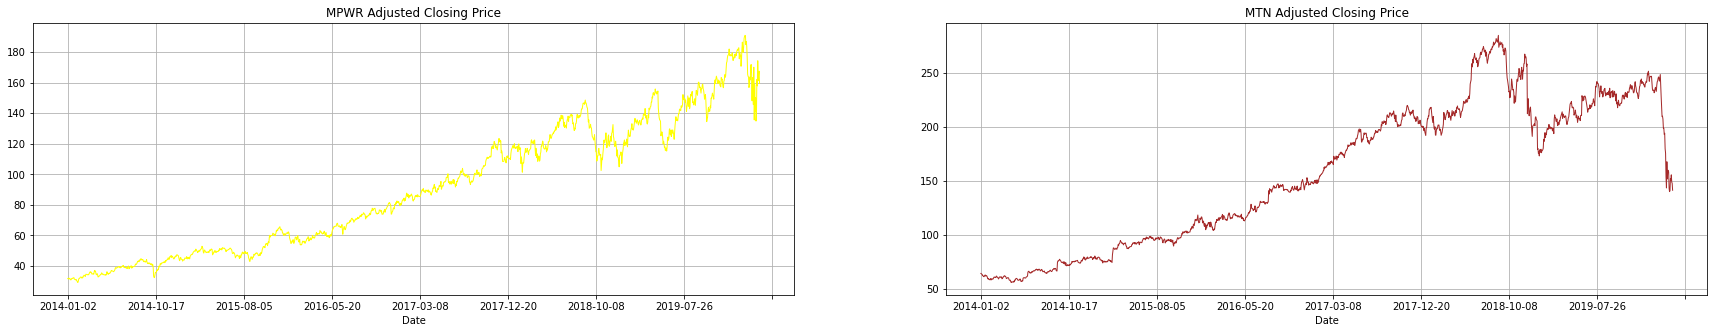

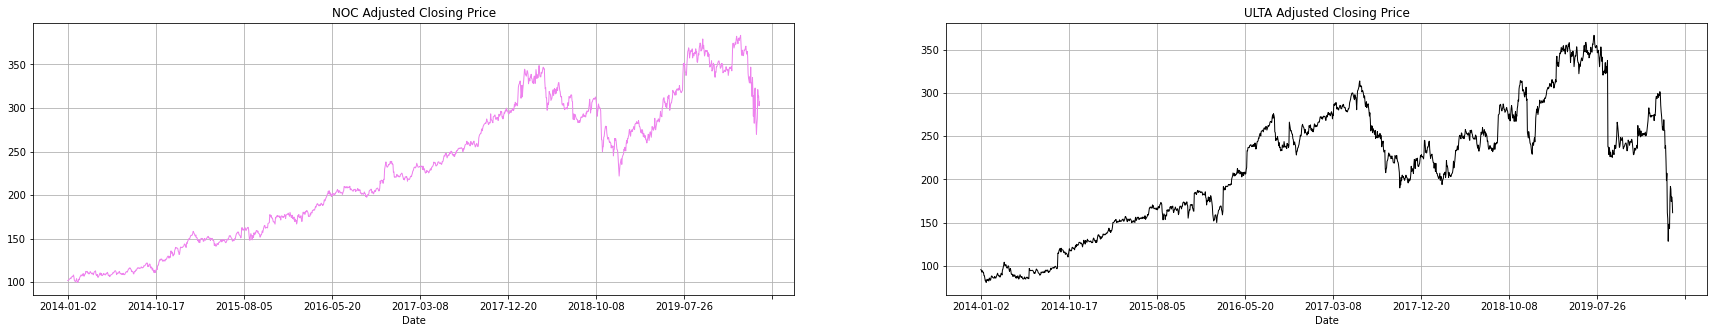

In [ ]:
figure, axes = plt.subplots(1, 2)
newDf[newDf['Ticker']=='ANET']['Adj Close'].plot(ax=axes[0], label='ANET', title='ANET Adjusted Closing Price', color='red', linewidth=1.0, grid=True, figsize=(30, 5))
newDf[newDf['Ticker']=='EQIX']['Adj Close'].plot(ax=axes[1], label='EQIX', title='EQIX Adjusted Closing Price', color='green', linewidth=1.0, grid=True, figsize=(30, 5))

figure, axes = plt.subplots(1, 2)
newDf[newDf['Ticker']=='FICO']['Adj Close'].plot(ax=axes[0], title='FICO Adjusted Closing Price', color='blue', linewidth=1.0, grid=True, figsize=(30, 5))
newDf[newDf['Ticker']=='FIVN']['Adj Close'].plot(ax=axes[1], title='FIVN Adjusted Closing Price', color='red', linewidth=1.0, grid=True, figsize=(30, 5))

figure, axes = plt.subplots(1, 2)
newDf[newDf['Ticker']=='MPWR']['Adj Close'].plot(ax=axes[0], title='MPWR Adjusted Closing Price', color='yellow', linewidth=1.0, grid=True, figsize=(30, 5))
newDf[newDf['Ticker']=='MTN']['Adj Close'].plot(ax=axes[1], title='MTN Adjusted Closing Price', color='brown', linewidth=1.0, grid=True, figsize=(30, 5))

figure, axes = plt.subplots(1, 2)
newDf[newDf['Ticker']=='NOC']['Adj Close'].plot(ax=axes[0], title='NOC Adjusted Closing Price', color='violet', linewidth=1.0, grid=True, figsize=(30, 5))
newDf[newDf['Ticker']=='ULTA']['Adj Close'].plot(ax=axes[1], title='ULTA Adjusted Closing Price', color='black', linewidth=1.0, grid=True, figsize=(30, 5))

From the above plots  we  can  conclude  that  the stocks with uptrends  are:-

1. EQIX
2. FIVN
3. NOC
4. FICO
5. MPWR

## Volume Analysis
Lets analyse the volume of  the stocks  traded  on  a single  day. We  see that  there  is an spike  on ULTA in 2016 and 2019. In order to understand what lead  to  the spike we can  google out.

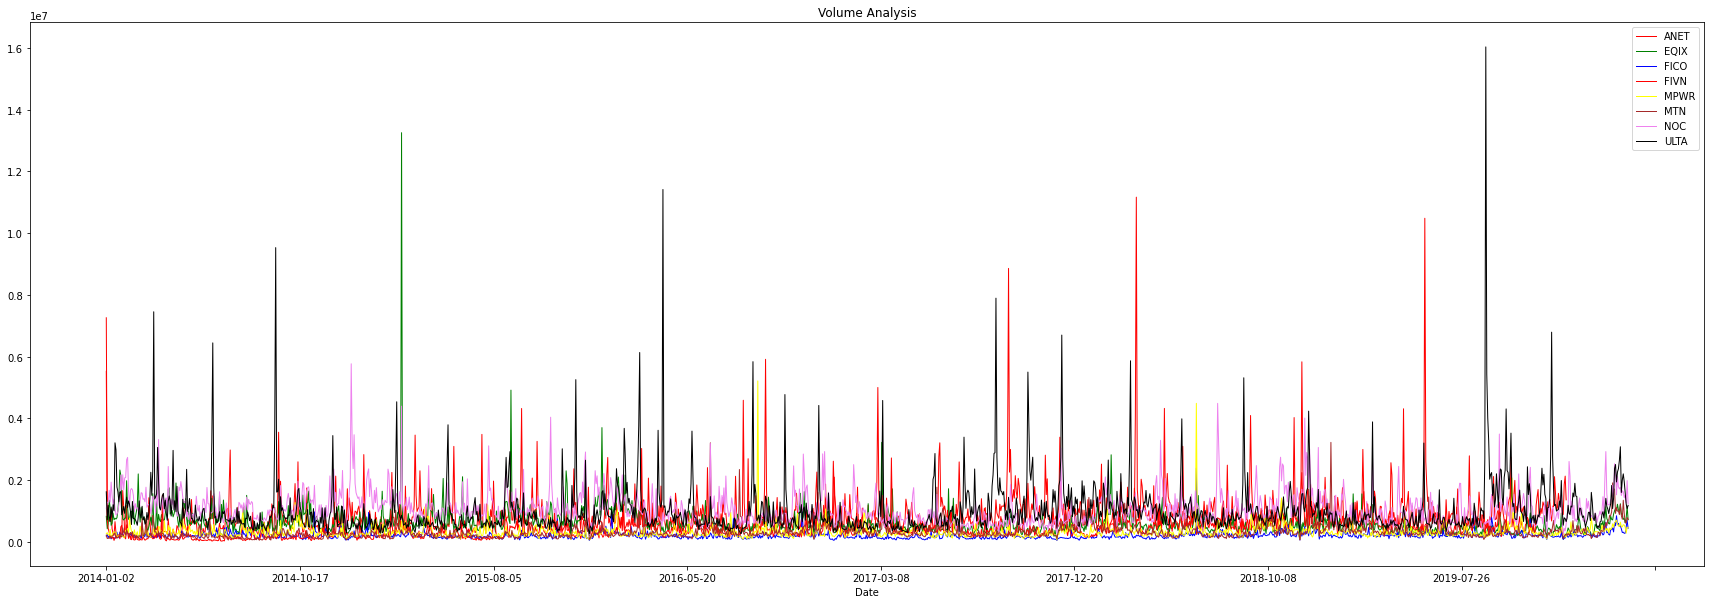

In [ ]:
newDf[newDf['Ticker']=='ANET']['Volume'].plot(label='ANET', title='Volume Analysis', color='red', linewidth=1.0, grid=True, figsize=(30, 10))
newDf[newDf['Ticker']=='EQIX']['Volume'].plot(label='EQIX',color='green', linewidth=1.0)
newDf[newDf['Ticker']=='FICO']['Volume'].plot(label='FICO',color='blue', linewidth=1.0)
newDf[newDf['Ticker']=='FIVN']['Volume'].plot(label='FIVN',color='red', linewidth=1.0)
newDf[newDf['Ticker']=='MPWR']['Volume'].plot(label='MPWR',color='yellow', linewidth=1.0)
newDf[newDf['Ticker']=='MTN']['Volume'].plot(label='MTN',color='brown', linewidth=1.0)
newDf[newDf['Ticker']=='NOC']['Volume'].plot(label='NOC',color='violet', linewidth=1.0)
newDf[newDf['Ticker']=='ULTA']['Volume'].plot(label='ULTA',color='black', linewidth=1.0)
plt.legend()

## Combine Adjusted  Close  value
This graph showcases the various  Adjusted Close valuees through the years. From this its evident that the **EQIX** stock has been performing consistantly  well.

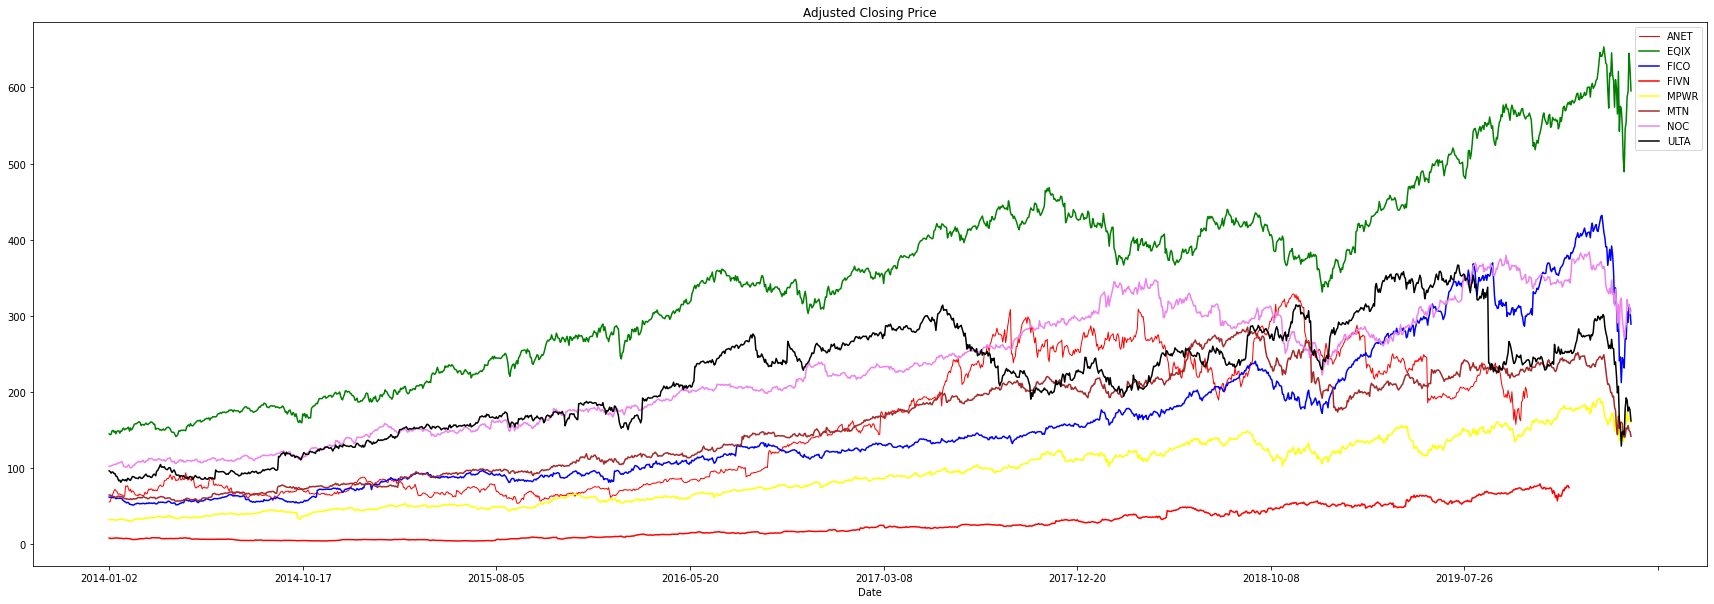

In [ ]:
# A Combine view of  the above  can be  seen below
newDf[newDf['Ticker']=='ANET']['Adj Close'].plot(label='ANET', title='Adjusted Closing Price', color='red', linewidth=1.0, grid=True, figsize=(30, 10))
newDf[newDf['Ticker']=='EQIX']['Adj Close'].plot(label='EQIX',color='green', linewidth=1.5)
newDf[newDf['Ticker']=='FICO']['Adj Close'].plot(label='FICO',color='blue', linewidth=1.5)
newDf[newDf['Ticker']=='FIVN']['Adj Close'].plot(label='FIVN',color='red', linewidth=1.5)
newDf[newDf['Ticker']=='MPWR']['Adj Close'].plot(label='MPWR',color='yellow', linewidth=1.5)
newDf[newDf['Ticker']=='MTN']['Adj Close'].plot(label='MTN',color='brown', linewidth=1.5)
newDf[newDf['Ticker']=='NOC']['Adj Close'].plot(label='NOC',color='violet', linewidth=1.5)
newDf[newDf['Ticker']=='ULTA']['Adj Close'].plot(label='ULTA',color='black', linewidth=1.5)
plt.legend()

##  Bollinger Bands

These  bands signifies  the  place  where  one should buy or  sell  the stock.  If the close price reaches the Upper  Band  we  recommend  selling  the  stock and  if it's touching   the lower  band we will  recommend buying  the  stock.

NOTE: Most place the upper  and lower band  have similar width. Wherever we see  a break in  the band  its wise  to  pull out or  analyze the trend and  look out  for some information that caused the anamoly.


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


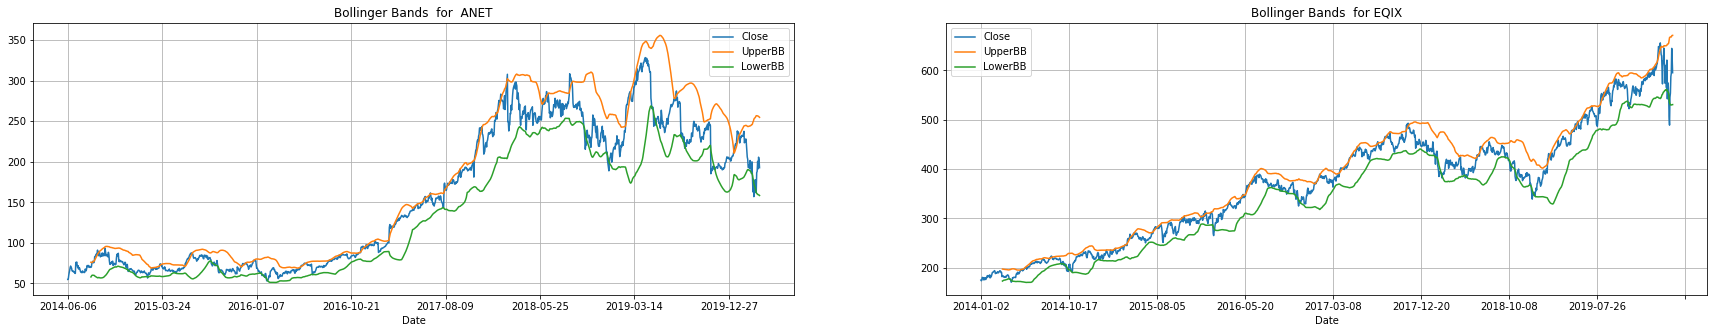

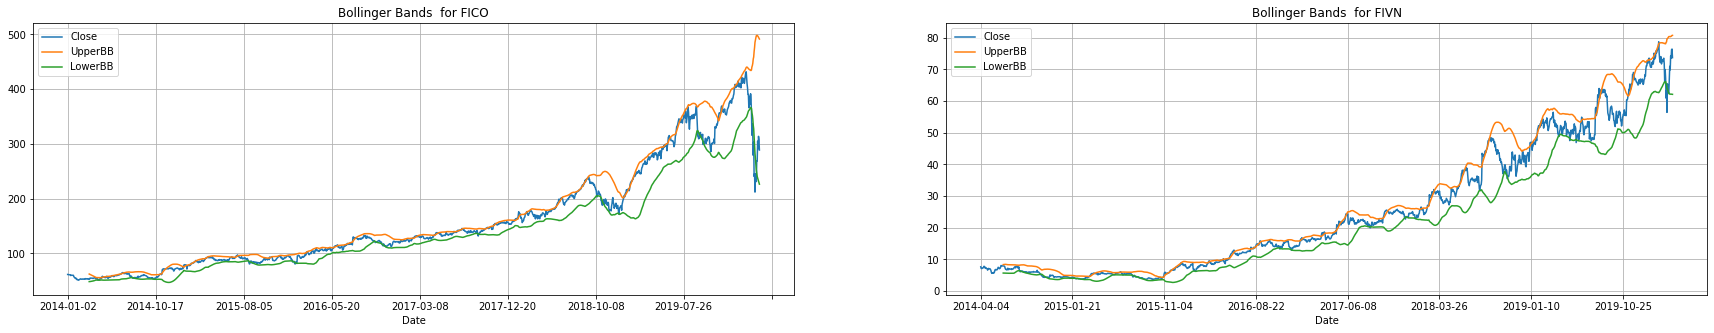

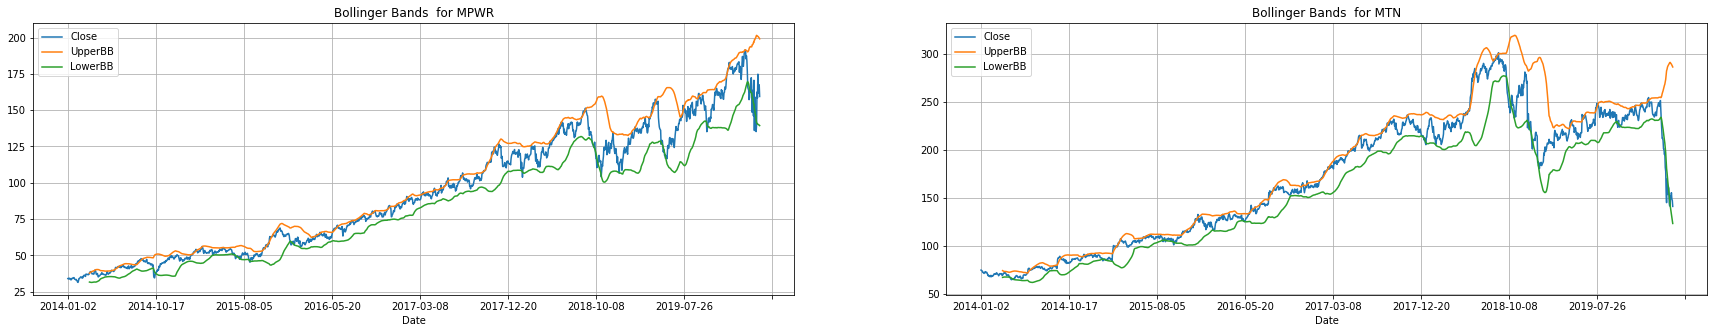

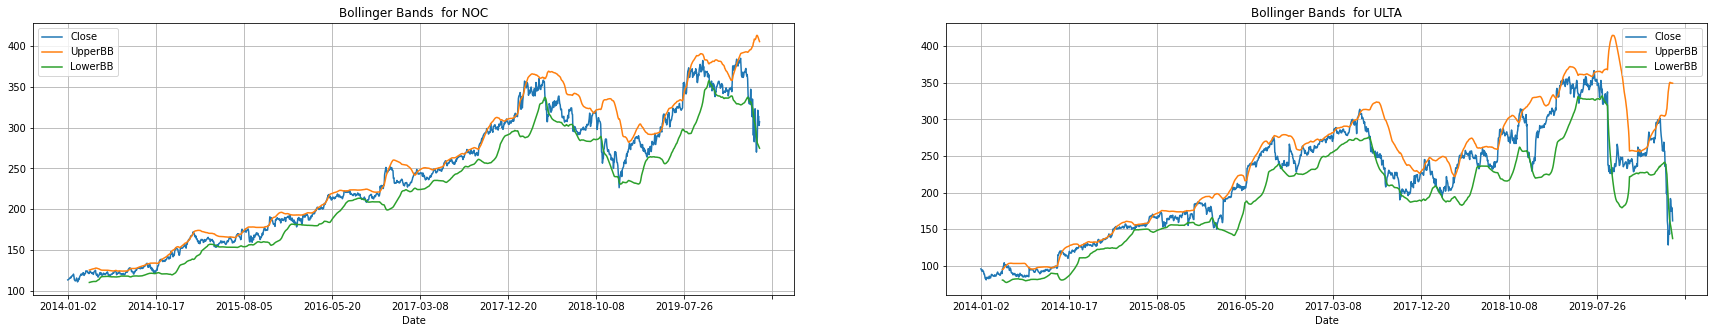

In [ ]:
# Compute the Bollinger Bands 
def BBANDS(data, window=50):
    MA = data.Close.rolling(window=n).mean()
    SD = data.Close.rolling(window=n).std()
    data['UpperBB'] = MA + (2 * SD) 
    data['LowerBB'] = MA - (2 * SD)
    return data

# Compute the Bollinger Bands for NIFTY using the 50-day Moving average['ANET', 'EQIX', 'FICO', 'FIVN', 'MPWR', 'MTN', 'NOC', 'ULTA']
n = 50

ANET_BBANDS = BBANDS(newDf[newDf['Ticker']=='ANET'], n)
EQIX_BBANDS = BBANDS(newDf[newDf['Ticker']=='EQIX'], n)
FICO_BBANDS = BBANDS(newDf[newDf['Ticker']=='FICO'], n)
FIVN_BBANDS = BBANDS(newDf[newDf['Ticker']=='FIVN'], n)
MPWR_BBANDS = BBANDS(newDf[newDf['Ticker']=='MPWR'], n)
MTN_BBANDS = BBANDS(newDf[newDf['Ticker']=='MTN'], n)
NOC_BBANDS = BBANDS(newDf[newDf['Ticker']=='NOC'], n)
ULTA_BBANDS = BBANDS(newDf[newDf['Ticker']=='ULTA'], n)

# Create the plot
figure, axes = plt.subplots(1, 2)
pd.concat([ANET_BBANDS.Close,ANET_BBANDS.UpperBB,ANET_BBANDS.LowerBB],axis=1).plot(figsize=(30,5),grid=True, ax=axes[0], title='Bollinger Bands  for  ANET')
pd.concat([EQIX_BBANDS.Close,EQIX_BBANDS.UpperBB,EQIX_BBANDS.LowerBB],axis=1).plot(figsize=(30,5),grid=True, ax=axes[1], title='Bollinger Bands  for EQIX')

figure, axes = plt.subplots(1, 2)
pd.concat([FICO_BBANDS.Close,FICO_BBANDS.UpperBB,FICO_BBANDS.LowerBB],axis=1).plot(figsize=(30,5),grid=True, ax=axes[0], title='Bollinger Bands  for FICO')
pd.concat([FIVN_BBANDS.Close,FIVN_BBANDS.UpperBB,FIVN_BBANDS.LowerBB],axis=1).plot(figsize=(30,5),grid=True, ax=axes[1], title='Bollinger Bands  for FIVN')

figure, axes = plt.subplots(1, 2)
pd.concat([MPWR_BBANDS.Close,MPWR_BBANDS.UpperBB,MPWR_BBANDS.LowerBB],axis=1).plot(figsize=(30,5),grid=True, ax=axes[0], title='Bollinger Bands  for MPWR')
pd.concat([MTN_BBANDS.Close,MTN_BBANDS.UpperBB,MTN_BBANDS.LowerBB],axis=1).plot(figsize=(30,5),grid=True, ax=axes[1], title='Bollinger Bands  for MTN')

figure, axes = plt.subplots(1, 2)
pd.concat([NOC_BBANDS.Close,NOC_BBANDS.UpperBB,NOC_BBANDS.LowerBB],axis=1).plot(figsize=(30,5),grid=True, ax=axes[0], title='Bollinger Bands  for NOC')
pd.concat([ULTA_BBANDS.Close,ULTA_BBANDS.UpperBB,ULTA_BBANDS.LowerBB],axis=1).plot(figsize=(30,5),grid=True, ax=axes[1], title='Bollinger Bands  for ULTA')

##   RSI Calculation (Relative Strendth Index)

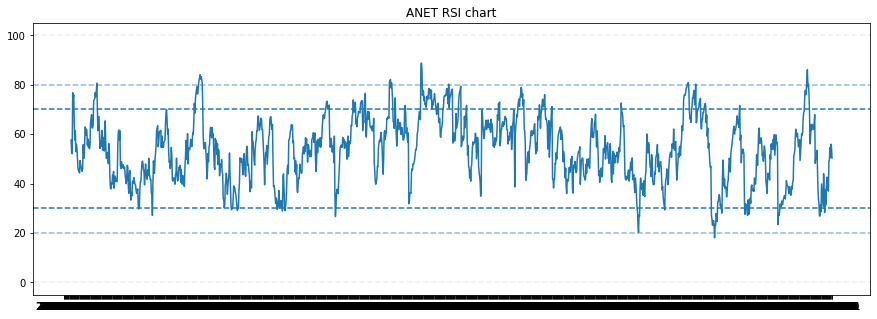

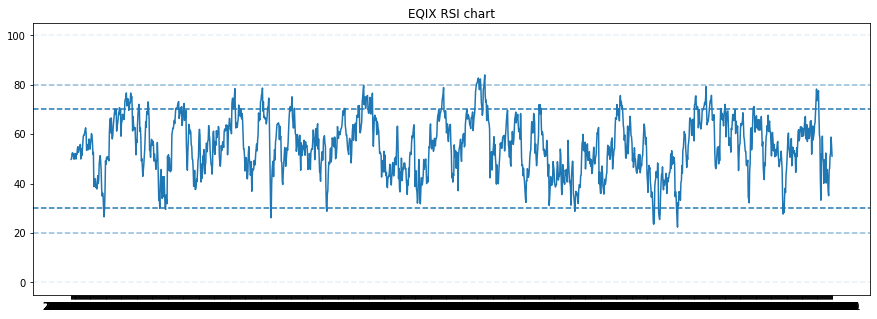

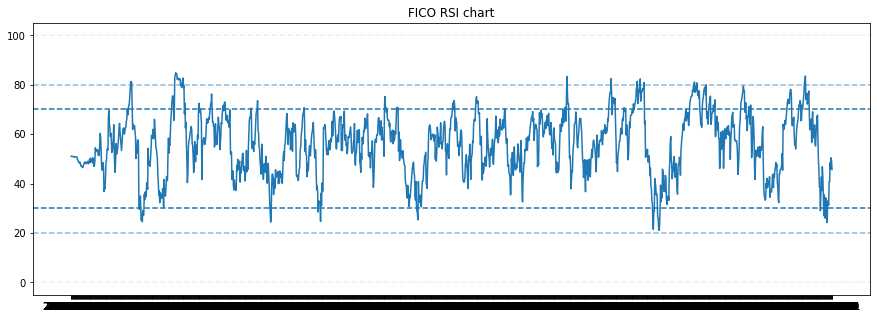

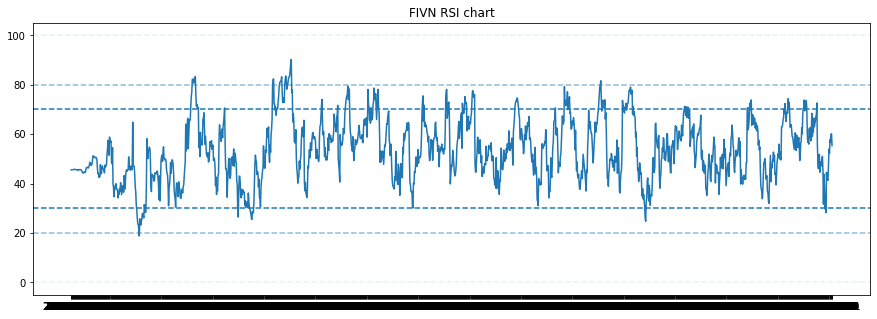

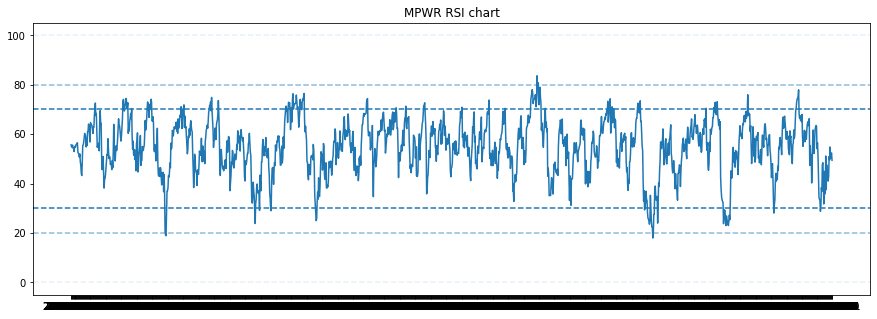

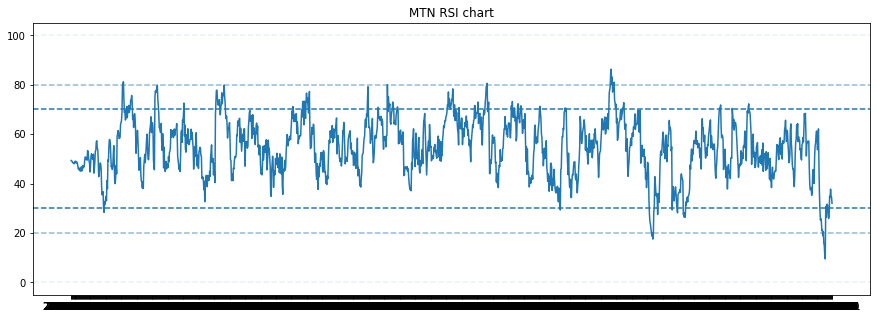

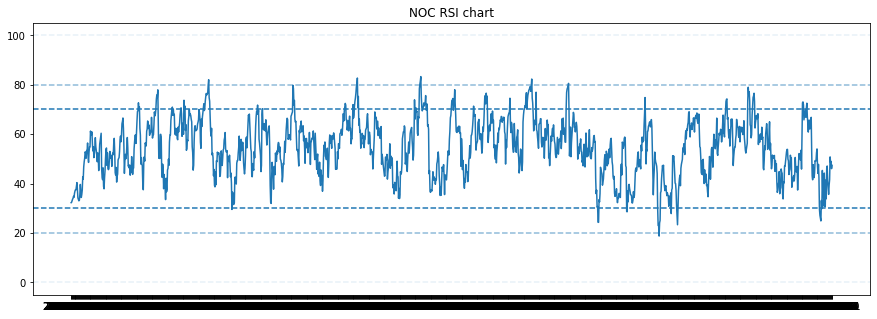

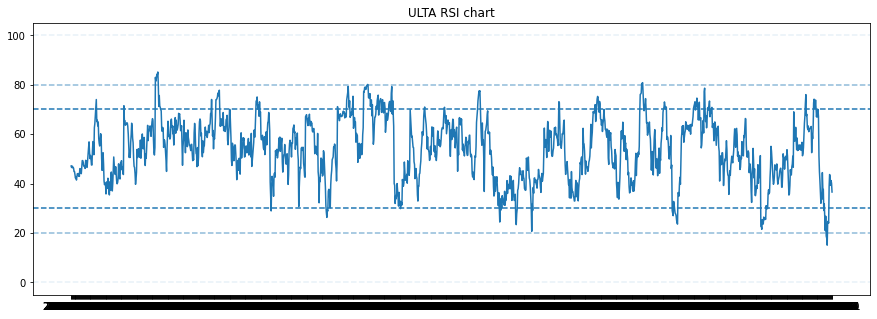

In [ ]:
# plot correspondingRSI values and significant levels
for ticker in  ['ANET', 'EQIX', 'FICO', 'FIVN', 'MPWR', 'MTN', 'NOC', 'ULTA']:
  plt.figure(figsize=(15,5))
  plt.title(ticker+' RSI chart')
  plt.plot(newDf[newDf['Ticker']==ticker].index, newDf[newDf['Ticker']==ticker]['RSI'])

  plt.axhline(0, linestyle='--', alpha=0.1)
  plt.axhline(20, linestyle='--', alpha=0.5)
  plt.axhline(30, linestyle='--')

  plt.axhline(70, linestyle='--')
  plt.axhline(80, linestyle='--', alpha=0.5)
  plt.axhline(100, linestyle='--', alpha=0.1)
  plt.show()

## Scraped Financial Data
We have  scraped data  related to  dividends and the sector. Here we can see  which companies from  the Golden  Cluster provide  highest  dividents  and  which companies are  related.

In [ ]:
# Plot the  Dividends
scrappedDf = scrappedDf[scrappedDf['Div_Val']!='N/A ']
scrappedDf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36 entries, 0 to 58
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Ticker   36 non-null     object
 1   Div_Val  36 non-null     object
 2   Sector   36 non-null     object
dtypes: object(3)
memory usage: 1.1+ KB


In [ ]:
scrappedDf['Div_Val'] = scrappedDf['Div_Val'].astype(float)
scrappedDf = scrappedDf.sort_values(by='Div_Val',  ascending=False)
scrappedDf.head(50)

Ticker  Div_Val                  Sector
58   AVGO    14.40              Technology
3    EQIX    11.48             Real Estate
0     NOC     5.80             Industrials
44   LRCX     5.20              Technology
12    UNH     5.00              Healthcare
10    DLR     4.64             Real Estate
31    ARE     4.36             Real Estate
57    EXR     4.00             Real Estate
15    DPZ     3.76       Consumer Cyclical
25    SUI     3.32             Real Estate
41   MSCI     3.12      Financial Services
9     LII     3.08             Industrials
32    STZ     3.00      Consumer Defensive
7    CTAS     3.00             Industrials
14    HUM     2.80              Healthcare
39   MKTX     2.64      Financial Services
6    MPWR     2.40              Technology
11   POOL     2.32       Consumer Cyclical
50    MLM     2.28         Basic Materials
56   NXPI     2.25              Technology
22   EVRG     2.14               Utilities
5     TSN     1.78      Consumer Defensive
37   FANG     1.60                  Energy
21    CDW     1.60              Technology
40    CFG     1.56      Financial Services
23    VMC     1.48         Basic Materials
13    BAH     1.48             Industrials
24    ELS     1.45             Real Estate
49    TTC     1.05             Industrials
20    AOS     1.04             Industrials
35    WCN     0.82             Industrials
36    FRC     0.80      Financial Services
45    GPN     0.78             Industrials
54   NTES     0.78  Communication Services
42    KDP     0.75      Consumer Defensive
26    WST     0.68              Healthcare

<BarContainer object of 36 artists>

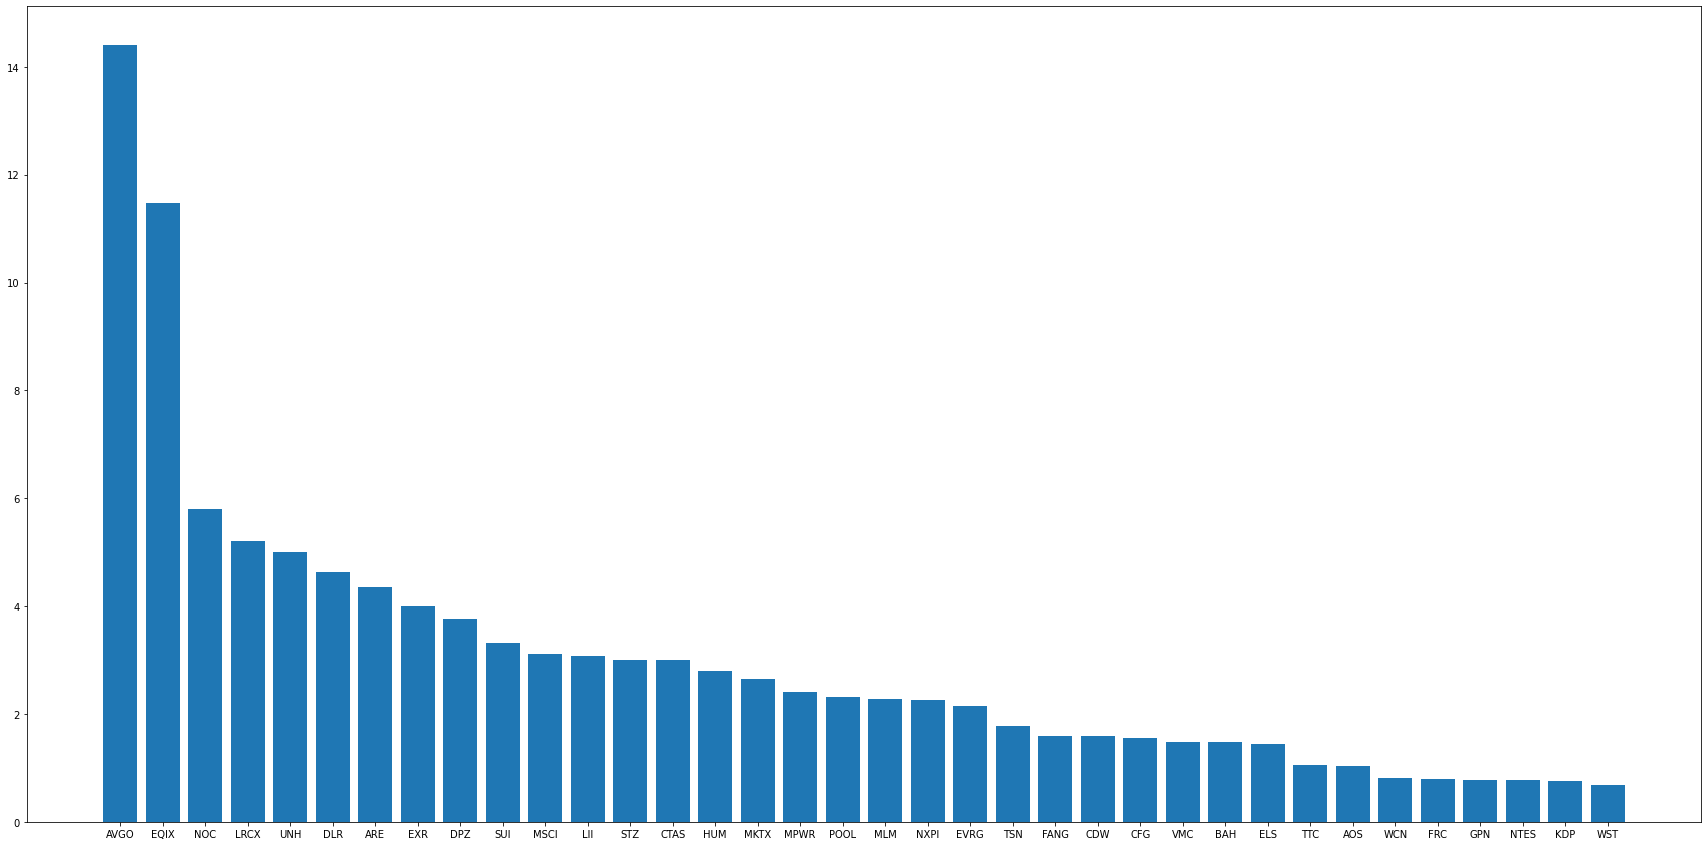

In [ ]:
plt.figure(figsize=(30,15))

plt.bar(scrappedDf.dropna()['Ticker'],scrappedDf.dropna(axis=1)['Div_Val'])


From the  above we  can  see that  the  highest  yiending  stocks are as follows:-

1. AVGO -	**14.40**	
2. EQIX	- **11.48**
3. NOC	- **5.80**	
4. LRCX	- **5.20**	
5. UNH	- **5.00**	
6. DLR	- **4.64**
7. ARE	- **4.36**
8. EXR	- **4.00**	

##   Companies working in  same  sectors are as follows
AVGO, LRCX, MPWR, NXPI, CWD  are  the companies that are  somehow related due to  the fact they work in  same technology sector. We can  get this from the  data mentioned below.

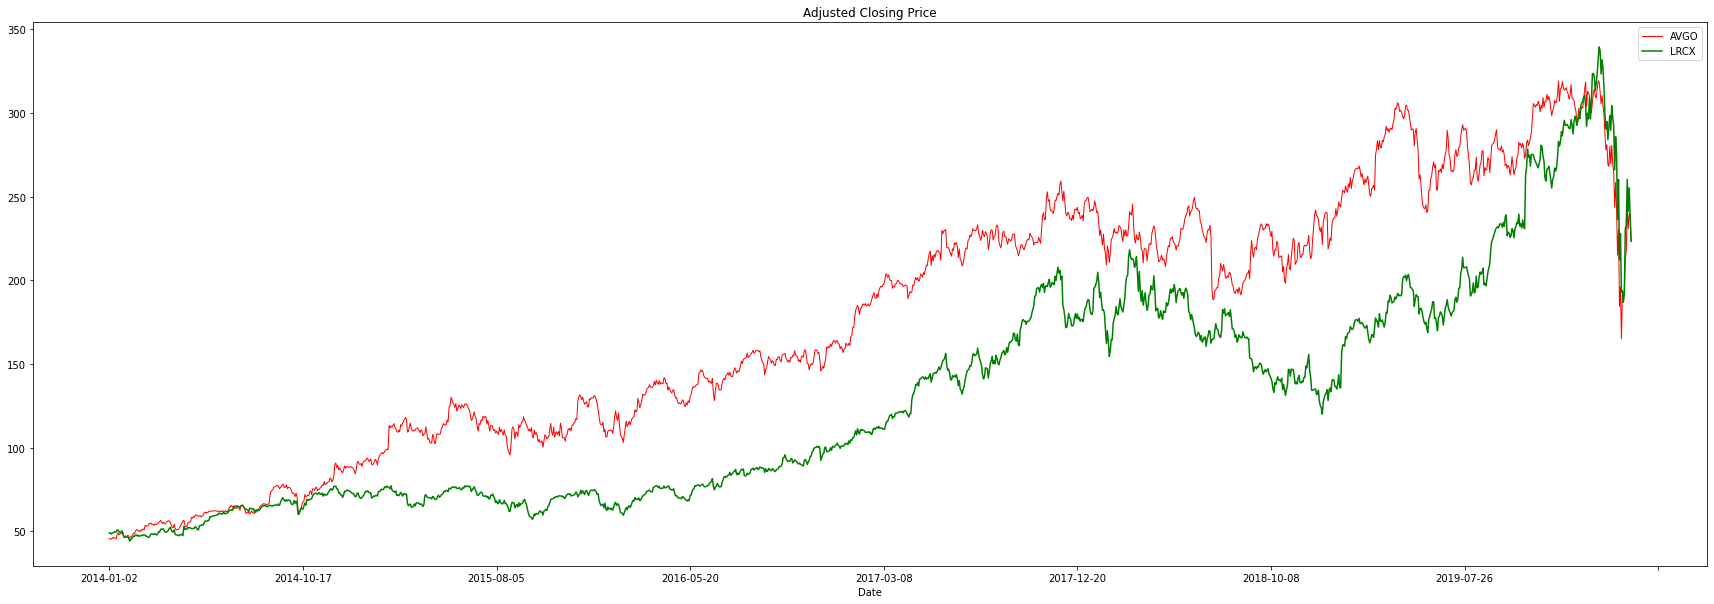

In [ ]:
df2 = df1
df2.set_index('Date',inplace=True)
df2[df2['Ticker']=='AVGO']['Adj Close'].plot(label='AVGO', title='Adjusted Closing Price', color='red', linewidth=1.0, grid=True, figsize=(30, 10))
df2[df2['Ticker']=='LRCX']['Adj Close'].plot(label='LRCX',color='green', linewidth=1.5)
plt.legend()


#Latent Variable calculation

- Bollinger band
- Bollinger Indicator
- RSI
- williams_r momentum

In [ ]:
appl = df[df.Ticker.isin(["EQIX"])]
appl = appl[appl.Year.isin([2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020])]

In [ ]:
appl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2579 entries, 7445752 to 7448330
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2579 non-null   object 
 1   Open       2579 non-null   float64
 2   High       2579 non-null   float64
 3   Low        2579 non-null   float64
 4   Close      2579 non-null   float64
 5   Adj Close  2579 non-null   float64
 6   Volume     2579 non-null   float64
 7   Ticker     2579 non-null   object 
 8   Year       2579 non-null   int64  
dtypes: float64(6), int64(1), object(2)
memory usage: 201.5+ KB


In [ ]:
indicator_bb = BollingerBands(close=appl["Close"], window=20, window_dev=2)
appl['bb_bbm'] = indicator_bb.bollinger_mavg()
appl['bb_bbh'] = indicator_bb.bollinger_hband()
appl['bb_bbl'] = indicator_bb.bollinger_lband()

appl['bb_bbhi'] = indicator_bb.bollinger_hband_indicator()

appl['bb_bbli'] = indicator_bb.bollinger_lband_indicator()

In [ ]:
appl['rsi']=rsi(close=appl["Close"], window=14, fillna=False)
appl['williams_r']=williams_r(high=appl["High"], low=appl["Low"], close=appl["Close"], lbp=14, fillna=False)

In [ ]:
appl.head()

Date        Open        High  ...  bb_bbli  rsi  williams_r
7445752  2010-01-04  106.519997  109.620003  ...      0.0  NaN         NaN
7445753  2010-01-05  109.589996  109.589996  ...      0.0  NaN         NaN
7445754  2010-01-06  108.949997  110.570000  ...      0.0  NaN         NaN
7445755  2010-01-07  109.250000  110.349998  ...      0.0  NaN         NaN
7445756  2010-01-08  106.800003  107.279999  ...      0.0  NaN         NaN

[5 rows x 16 columns]

#Target Variable Generation

In [ ]:
appl["Target"] = 0
appl.loc[appl.Close < appl.bb_bbl, "Target"] =0 #Buy

appl.loc[(appl.bb_bbl <= appl.Close) & (appl.Close <appl.bb_bbm), "Target"] =1 # 'Hold Buy/ Liquidate Short'

appl.loc[(appl.bb_bbm <= appl.Close) & (appl.Close<appl.bb_bbh), "Target"] =2 # 'Hold Short/ Liquidate Buy'

appl.loc[appl.Close>=appl.bb_bbh,"Target"]=3 # 'Short'
appl.head()

Date        Open        High  ...  rsi  williams_r  Target
7445752  2010-01-04  106.519997  109.620003  ...  NaN         NaN       0
7445753  2010-01-05  109.589996  109.589996  ...  NaN         NaN       0
7445754  2010-01-06  108.949997  110.570000  ...  NaN         NaN       0
7445755  2010-01-07  109.250000  110.349998  ...  NaN         NaN       0
7445756  2010-01-08  106.800003  107.279999  ...  NaN         NaN       0

[5 rows x 17 columns]

#Feature Importance

In [ ]:
appl.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Ticker',
       'Year', 'bb_bbm', 'bb_bbh', 'bb_bbl', 'bb_bbhi', 'bb_bbli', 'rsi',
       'williams_r', 'Target'],
      dtype='object')

In [ ]:
appl=appl.dropna()

In [ ]:
X=appl[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume','bb_bbm', 'bb_bbh', 'bb_bbl', 'bb_bbhi', 'bb_bbli', 'rsi',
       'williams_r']]
y=appl[['Target']]

In [ ]:
X.head()

Open       High        Low  ...  bb_bbli        rsi  williams_r
7445771  96.690002  97.820000  95.300003  ...      0.0  20.369729  -95.546595
7445772  95.910004  97.239998  94.680000  ...      0.0  24.788405  -83.592390
7445773  96.519997  97.290001  95.279999  ...      0.0  23.664819  -88.601041
7445774  95.330002  95.750000  92.550003  ...      0.0  18.545379  -98.760042
7445775  92.879997  93.120003  90.489998  ...      0.0  20.078070  -84.147119

[5 rows x 13 columns]

In [ ]:
y.head()

Target
7445771       1
7445772       1
7445773       1
7445774       1
7445775       1

###SelectKBest Method

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Feature Open: 0.0824807214787231
Feature High: 0.10123842001910943
Feature Low: 0.09380122888461684
Feature Close: 0.1417937819728574
Feature Adj Close: 0.15573976941584156
Feature Volume: 0.02147537221709861
Feature bb_bbm: 0.07298012242411178
Feature bb_bbh: 0.0792710029329271
Feature bb_bbl: 0.07129905865171882
Feature bb_bbhi: 0.25328379910361076
Feature bb_bbli: 0.17074223334646588
Feature rsi: 0.5758112636792447
Feature williams_r: 0.5848769720371367


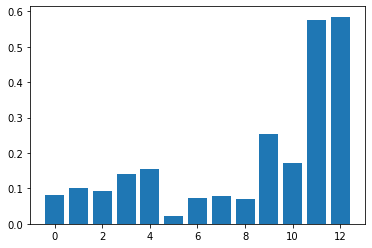

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

for predictor, score in zip(X.columns,fs.scores_):
	print("Feature {}: {}".format(predictor,score))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

###Feature Importance using Decision Tree Classifier model

Feature: Open, Score: 0.00479
Feature: High, Score: 0.00000
Feature: Low, Score: 0.00494
Feature: Close, Score: 0.00450
Feature: Adj Close, Score: 0.00596
Feature: Volume, Score: 0.02885
Feature: bb_bbm, Score: 0.00420
Feature: bb_bbh, Score: 0.00368
Feature: bb_bbl, Score: 0.01229
Feature: bb_bbhi, Score: 0.18830
Feature: bb_bbli, Score: 0.12595
Feature: rsi, Score: 0.49336
Feature: williams_r, Score: 0.12317


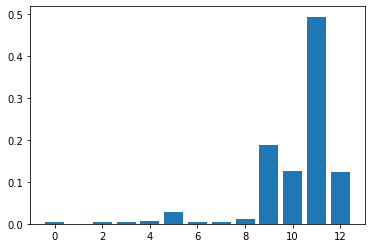

In [ ]:
model = DecisionTreeClassifier()
# fit the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
model.fit(X_train, y_train)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %s, Score: %.5f' % (X.columns[i],v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

###SHAP Method

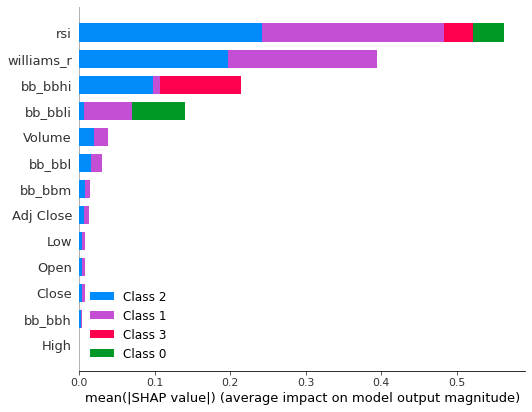

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, plot_type="bar")

#Classification

In [ ]:
classifier_names = ["Linear SVM", "RBF SVM",
         "Decision Tree", "Random Forest", "Neural Net"
         , "AdaBoost","Naive Bayes"]
classifiers = [
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB()
    ]

In [ ]:
X.head()

Open       High        Low  ...  bb_bbli        rsi  williams_r
7445771  96.690002  97.820000  95.300003  ...      0.0  20.369729  -95.546595
7445772  95.910004  97.239998  94.680000  ...      0.0  24.788405  -83.592390
7445773  96.519997  97.290001  95.279999  ...      0.0  23.664819  -88.601041
7445774  95.330002  95.750000  92.550003  ...      0.0  18.545379  -98.760042
7445775  92.879997  93.120003  90.489998  ...      0.0  20.078070  -84.147119

[5 rows x 13 columns]

##Muller Loop without Feature Importance

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Classifier = Linear SVM, Score (test, accuracy) = 94.73, Training time = 0.05 seconds


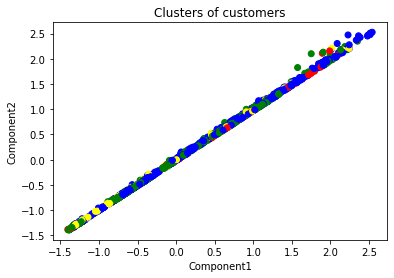

Confusion Matrix


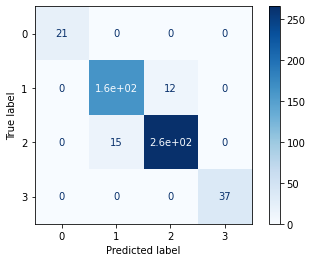

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Classifier = RBF SVM, Score (test, accuracy) = 93.95, Training time = 0.25 seconds


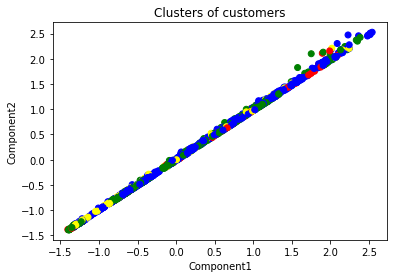

Confusion Matrix


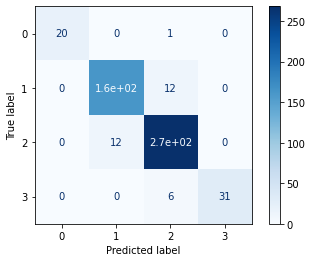

Classifier = Decision Tree, Score (test, accuracy) = 94.73, Training time = 0.02 seconds


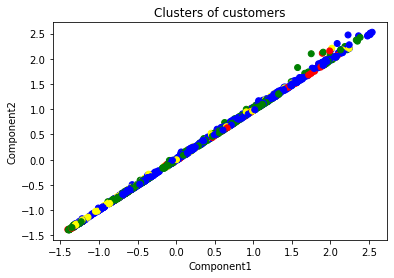

Confusion Matrix


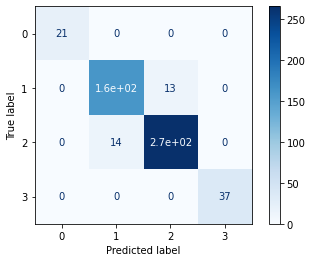

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Classifier = Random Forest, Score (test, accuracy) = 87.89, Training time = 0.04 seconds


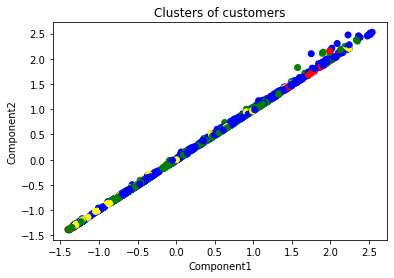

Confusion Matrix


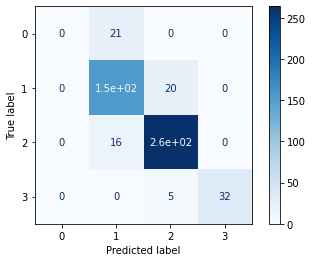

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Classifier = Neural Net, Score (test, accuracy) = 94.34, Training time = 1.79 seconds


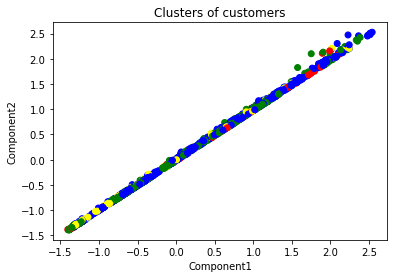

Confusion Matrix


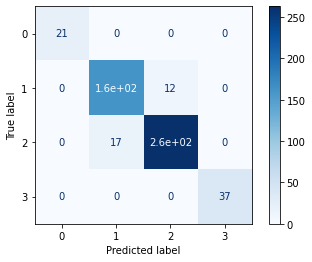

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Classifier = AdaBoost, Score (test, accuracy) = 92.38, Training time = 0.30 seconds


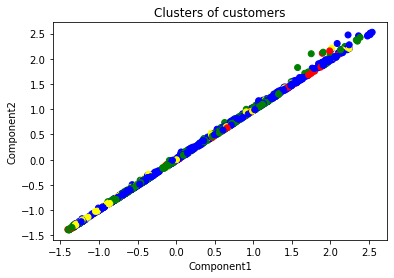

Confusion Matrix


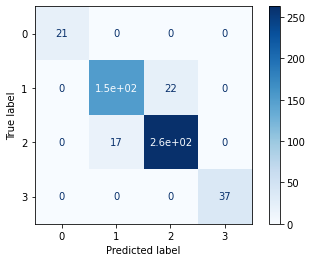

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Classifier = Naive Bayes, Score (test, accuracy) = 93.75, Training time = 0.01 seconds


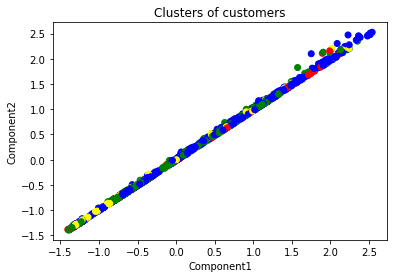

Confusion Matrix


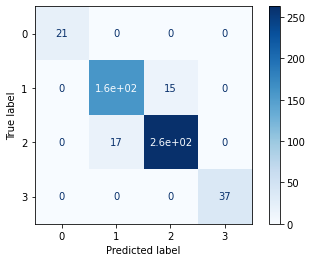

+---------------+------------+--------------------+--------------------+--------------------+
|     Model     |  Accuracy  |      F1 Score      |     Precision      |       Recall       |
+---------------+------------+--------------------+--------------------+--------------------+
|   Linear SVM  | 94.7265625 | 0.9686507388482253 | 0.9679832344122866 | 0.969365763546798  |
|    RBF SVM    | 93.9453125 | 0.9409338058495367 | 0.9662080980415715 | 0.919599032530067  |
| Decision Tree | 94.7265625 | 0.9685838916198082 | 0.9683512544802867 | 0.9688218390804597 |
| Random Forest | 87.890625  | 0.6748289023266493 | 0.6799443830504176 | 0.6731948697465939 |
|   Neural Net  | 94.3359375 | 0.9663986933108747 | 0.9653478923311326 | 0.9675800492610838 |
|    AdaBoost   | 92.3828125 | 0.954317706855182  | 0.955553825391882  | 0.9532122331691297 |
|  Naive Bayes  |   93.75    | 0.9628059395801332 | 0.9623630640941792 | 0.9632697044334975 |
+---------------+------------+--------------------+---------

In [ ]:
type="classifier_WOLV"
muller_loop_classifier(classifier_names, classifiers, X, y,type)

In [ ]:
classifier= load('/content/drive/MyDrive/MLSpring-2021/MLSpring-2021/teams/musketeers/Midterm/PickleModel/classifier_WOLV_Linear SVM')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)  
prediction = classifier.predict(X_test)
print("Probability ", prediction)

Probability  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1

##Muller Loop with Feature Importance

In [ ]:
X=X[['rsi','williams_r','bb_bbhi','bb_bbli']]

In [ ]:
X.head()

rsi  williams_r  bb_bbhi  bb_bbli
7445771  20.369729  -95.546595      0.0      0.0
7445772  24.788405  -83.592390      0.0      0.0
7445773  23.664819  -88.601041      0.0      0.0
7445774  18.545379  -98.760042      0.0      0.0
7445775  20.078070  -84.147119      0.0      0.0

In [ ]:
y.head()

Target
7445771       1
7445772       1
7445773       1
7445774       1
7445775       1

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Classifier = Linear SVM, Score (test, accuracy) = 92.38, Training time = 0.03 seconds


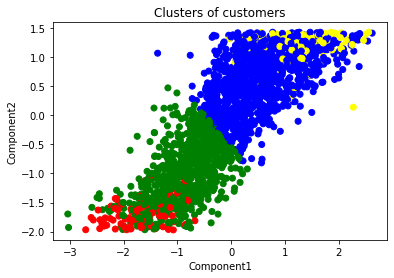

Confusion Matrix


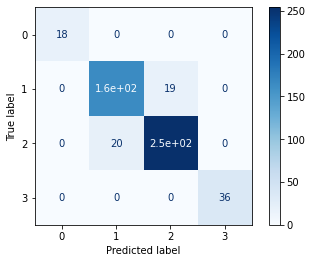

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Classifier = RBF SVM, Score (test, accuracy) = 92.97, Training time = 0.06 seconds


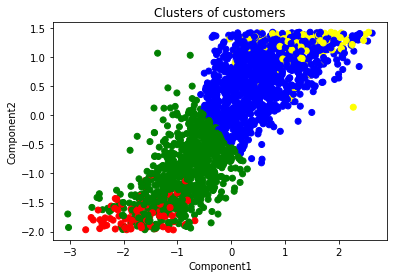

Confusion Matrix


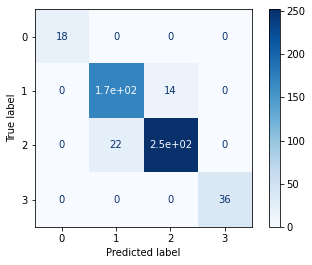

Classifier = Decision Tree, Score (test, accuracy) = 92.97, Training time = 0.01 seconds


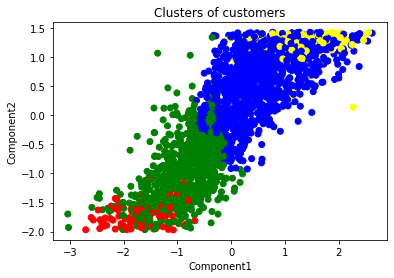

Confusion Matrix


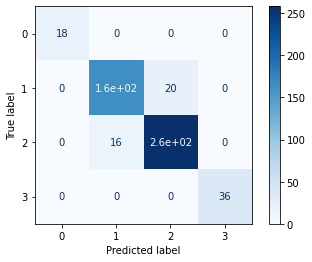

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Classifier = Random Forest, Score (test, accuracy) = 92.77, Training time = 0.04 seconds


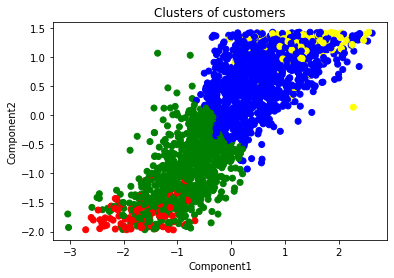

Confusion Matrix


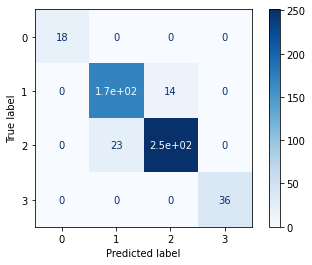

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Classifier = Neural Net, Score (test, accuracy) = 92.77, Training time = 1.45 seconds


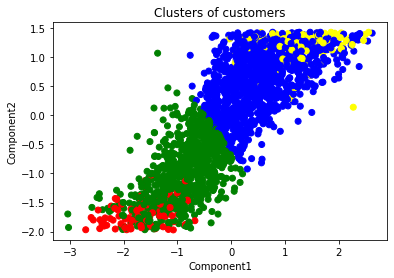

Confusion Matrix


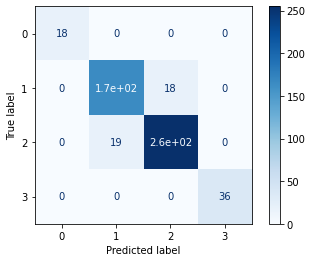

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Classifier = AdaBoost, Score (test, accuracy) = 89.65, Training time = 0.18 seconds


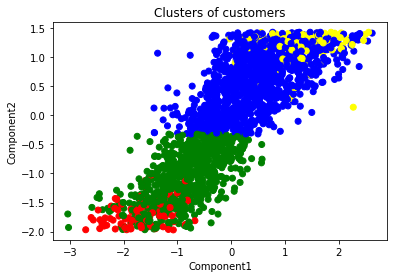

Confusion Matrix


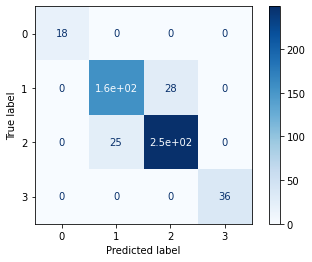

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Classifier = Naive Bayes, Score (test, accuracy) = 92.19, Training time = 0.01 seconds


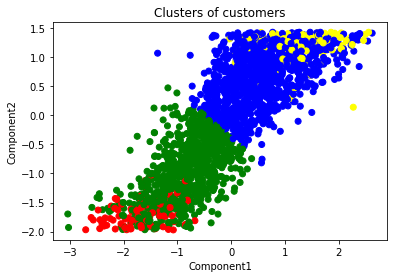

Confusion Matrix


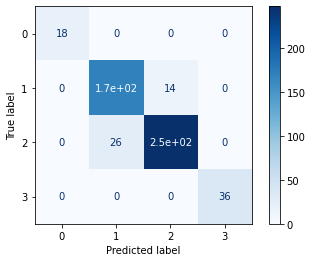

+---------------+------------+--------------------+--------------------+--------------------+
|     Model     |  Accuracy  |      F1 Score      |     Precision      |       Recall       |
+---------------+------------+--------------------+--------------------+--------------------+
|   Linear SVM  | 92.3828125 | 0.9557527385145881 | 0.9555737055737056 | 0.9559366074262139 |
|    RBF SVM    |  92.96875  | 0.9593971631205673 | 0.9581962719298245 | 0.9609052681688353 |
| Decision Tree |  92.96875  | 0.9589703774486382 | 0.9597921662669864 | 0.9582275468105363 |
| Random Forest | 92.7734375 | 0.9583027809628795 | 0.956999706716199  | 0.9599928594097111 |
|   Neural Net  | 92.7734375 | 0.9580218288471734 | 0.9578408078408078 | 0.9582077118375119 |
|    AdaBoost   | 89.6484375 | 0.939651443204137  | 0.9401988551369248 | 0.9391463027610283 |
|  Naive Bayes  |  92.1875   | 0.9550274941084054 | 0.9534779560679234 | 0.957255633132339  |
+---------------+------------+--------------------+---------

In [ ]:
type="classifier_WLV"
muller_loop_classifier(classifier_names, classifiers, X, y,type)

##Classifier prediction loading pickle file

In [ ]:
classifier= load('/content/drive/MyDrive/MLSpring-2021/MLSpring-2021/teams/musketeers/Midterm/PickleModel/classifier_WLV_Decision Tree')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)  
prediction = classifier.predict(X_test)
print("Probability ", prediction)

Probability  [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2

# Regression

From the above Fractal clustering we were able to narrow down the stocks that can considerd for our investment. Stocks considered had low variance and high yearly returns. 

## Prediction using Golden Cluster data

In [ ]:
golden_cluster1 = best_sub_cluster

In [ ]:
golden_cluster1 = golden_cluster1.sort_values(by="variance", ascending=True, axis=0)

Calculating sharpe ratio for the stocks

In [ ]:
golden_cluster1 = get_sharpe_ratio(golden_cluster1)
golden_cluster1.head()

Ticker  avg_yearly_returns  ...   std_dev  sharpe_ratio
254    NOC            0.271557  ...  0.020199     12.496238
22    ANET            0.262069  ...  0.026923      9.023071
352   ULTA            0.389413  ...  0.057795      6.406656
119   EQIX            0.264044  ...  0.066368      3.690034
136   FICO            0.243818  ...  0.075840      2.962507

[5 rows x 7 columns]

In [ ]:
tickersDf = golden_cluster1['Ticker']

In [ ]:
appl = df[df.Ticker.isin(["EQIX"])]
appl = appl[appl.Year.isin([2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020])]

In [ ]:
appl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2579 entries, 7445752 to 7448330
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2579 non-null   object 
 1   Open       2579 non-null   float64
 2   High       2579 non-null   float64
 3   Low        2579 non-null   float64
 4   Close      2579 non-null   float64
 5   Adj Close  2579 non-null   float64
 6   Volume     2579 non-null   float64
 7   Ticker     2579 non-null   object 
 8   Year       2579 non-null   int64  
dtypes: float64(6), int64(1), object(2)
memory usage: 201.5+ KB


In [ ]:
appl.set_index('Date', inplace=True)
appl.head(100)

Open        High         Low  ...     Volume  Ticker  Year
Date                                            ...                         
2010-01-04  106.519997  109.620003  106.510002  ...   576300.0    EQIX  2010
2010-01-05  109.589996  109.589996  108.379997  ...   681900.0    EQIX  2010
2010-01-06  108.949997  110.570000  108.220001  ...  1397500.0    EQIX  2010
2010-01-07  109.250000  110.349998  106.639999  ...   797200.0    EQIX  2010
2010-01-08  106.800003  107.279999  105.900002  ...   432400.0    EQIX  2010
...                ...         ...         ...  ...        ...     ...   ...
2010-05-20   94.760002   95.660004   92.050003  ...  1313900.0    EQIX  2010
2010-05-21   91.449997   93.699997   90.519997  ...  1217500.0    EQIX  2010
2010-05-24   91.809998   93.250000   91.419998  ...   775200.0    EQIX  2010
2010-05-25   89.849998   91.059998   87.860001  ...   714200.0    EQIX  2010
2010-05-26   91.449997   94.260002   91.099998  ...   884800.0    EQIX  2010

[100 rows x 8 columns]

In [ ]:
appl = appl.drop(['Ticker'], axis=1)

In [ ]:
appl.tail()

Open        High         Low  ...   Adj Close     Volume  Year
Date                                            ...                             
2020-03-26  559.530029  604.250000  551.260010  ...  587.580017   754700.0  2020
2020-03-27  573.520020  605.000000  553.900024  ...  594.270020   616200.0  2020
2020-03-30  605.989990  649.000000  594.020020  ...  644.869995   778600.0  2020
2020-03-31  640.000000  644.929993  611.059998  ...  624.570007  1135000.0  2020
2020-04-01  608.179993  620.000000  580.690002  ...  595.460022   714800.0  2020

[5 rows x 7 columns]

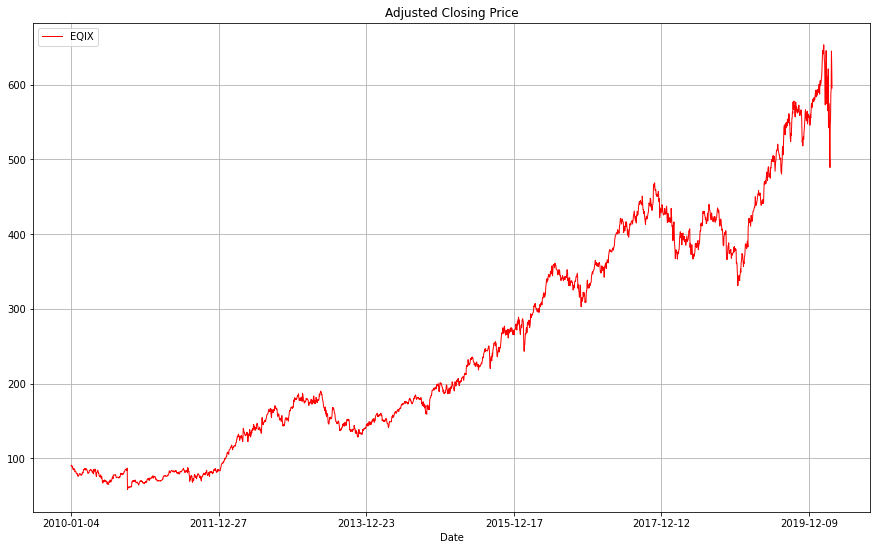

In [ ]:
# Visualizing the stock prices

appl['Adj Close'].plot(label='EQIX', figsize=(15, 9), title='Adjusted Closing Price', color='red', linewidth=1.0, grid=True)
plt.legend()

In [ ]:
# Rolling Mean / Moving Average 
close_col = appl['Adj Close']
mvag = close_col.rolling(window=100).mean()   

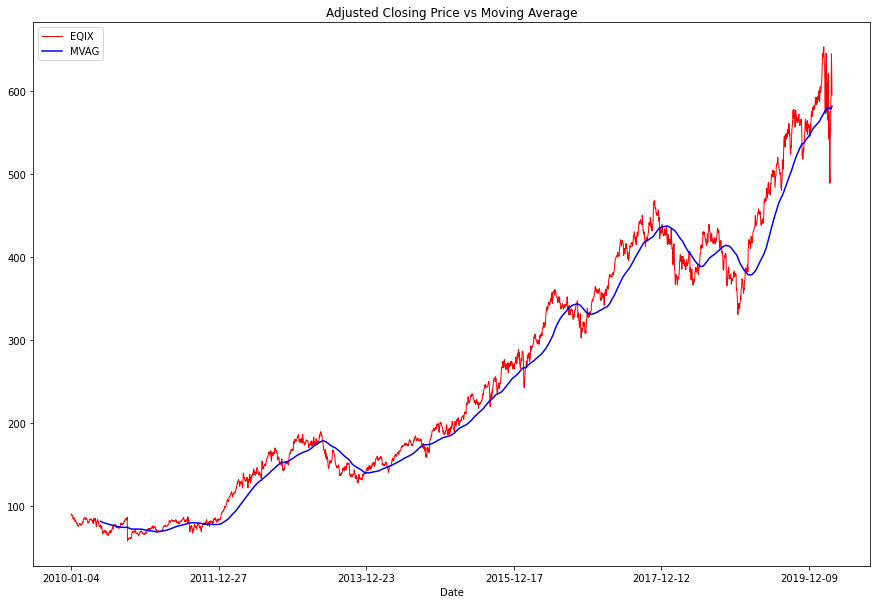

In [ ]:
# Visualizing Rolling Mean and Adjusted Closing Price together

appl['Adj Close'].plot(label='EQIX', figsize=(15,10), title='Adjusted Closing Price vs Moving Average', color='red', linewidth=1.0, grid=True)
mvag.plot(label='MVAG', color='blue')
plt.legend()

Return Deviation measures the Mean of the Probability Distribution of Investment Returns if it has a positive/negative Average Net Outcome

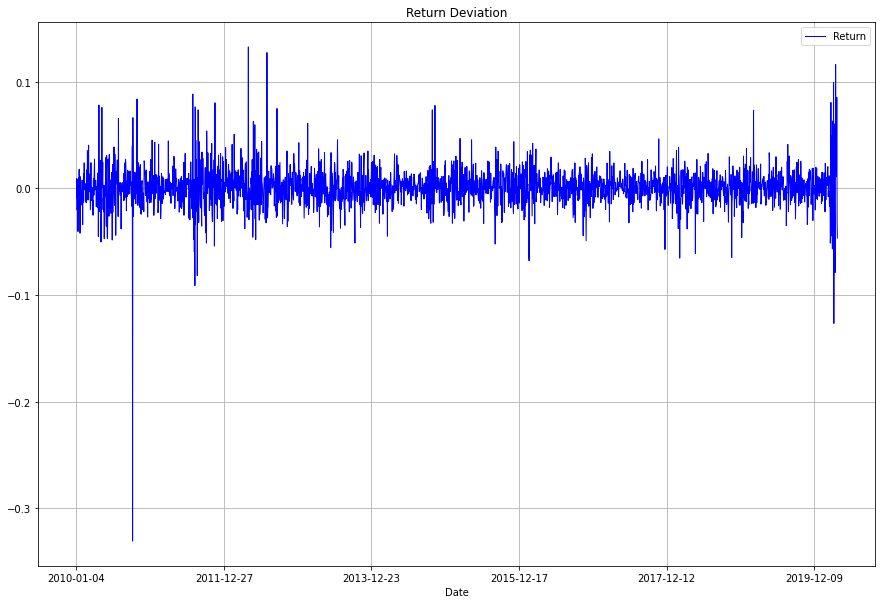

In [ ]:
rd = close_col / close_col.shift(1) - 1
rd.plot(label='Return', figsize=(15, 10), title='Return Deviation', color='blue', linewidth=1.0, grid=True)
plt.legend()

Number of days for which to predict the stock prices

In [ ]:
predict_days = 30

In [ ]:
# Shifting by the Number of Predict days for Prediction array
appl['Prediction'] = appl['Adj Close'].shift(-predict_days)
print(appl['Prediction'])
print(appl['Adj Close'])

Date
2010-01-04    79.569298
2010-01-05    78.617905
2010-01-06    78.601364
2010-01-07    78.187714
2010-01-08    77.128777
                ...    
2020-03-26          NaN
2020-03-27          NaN
2020-03-30          NaN
2020-03-31          NaN
2020-04-01          NaN
Name: Prediction, Length: 2579, dtype: float64
Date
2010-01-04     90.638535
2010-01-05     89.794678
2010-01-06     90.613678
2010-01-07     88.760551
2010-01-08     88.330353
                 ...    
2020-03-26    587.580017
2020-03-27    594.270020
2020-03-30    644.869995
2020-03-31    624.570007
2020-04-01    595.460022
Name: Adj Close, Length: 2579, dtype: float64


In [ ]:
appl.tail()

Open        High         Low  ...     Volume  Year  Prediction
Date                                            ...                             
2020-03-26  559.530029  604.250000  551.260010  ...   754700.0  2020         NaN
2020-03-27  573.520020  605.000000  553.900024  ...   616200.0  2020         NaN
2020-03-30  605.989990  649.000000  594.020020  ...   778600.0  2020         NaN
2020-03-31  640.000000  644.929993  611.059998  ...  1135000.0  2020         NaN
2020-04-01  608.179993  620.000000  580.690002  ...   714800.0  2020         NaN

[5 rows x 8 columns]

In [ ]:
X = np.array(appl.drop(['Prediction'], axis = 1))
X = X[:-predict_days]      # Size upto predict days
print(X)
print(X.shape)

[[1.06519997e+02 1.09620003e+02 1.06510002e+02 ... 9.06385345e+01
  5.76300000e+05 2.01000000e+03]
 [1.09589996e+02 1.09589996e+02 1.08379997e+02 ... 8.97946777e+01
  6.81900000e+05 2.01000000e+03]
 [1.08949997e+02 1.10570000e+02 1.08220001e+02 ... 9.06136780e+01
  1.39750000e+06 2.01000000e+03]
 ...
 [6.39090027e+02 6.54320007e+02 6.37190002e+02 ... 6.45974548e+02
  4.38600000e+05 2.02000000e+03]
 [6.44169983e+02 6.49989990e+02 6.39349976e+02 ... 6.40935425e+02
  4.27900000e+05 2.02000000e+03]
 [6.48190002e+02 6.50109985e+02 6.41400024e+02 ... 6.41064880e+02
  4.05000000e+05 2.02000000e+03]]
(2549, 7)


In [ ]:
y = np.array(appl['Prediction'])
y = y[:-predict_days]      # Size upto predict_days
# print(y)
print(y.shape)

(2549,)


Splitting the data into Training data and Testing data, performing split of 80% for training & 20% for testing

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)      
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2039, 7)
(2039,)
(510, 7)
(510,)


In [ ]:
appl.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2579 entries, 2010-01-04 to 2020-04-01
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        2579 non-null   float64
 1   High        2579 non-null   float64
 2   Low         2579 non-null   float64
 3   Close       2579 non-null   float64
 4   Adj Close   2579 non-null   float64
 5   Volume      2579 non-null   float64
 6   Year        2579 non-null   int64  
 7   Prediction  2549 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 181.3+ KB


In [ ]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
linear_model_score = linear_model.score(X_test, y_test)
print('Linear Model score:', linear_model_score)

Linear Model score: 0.9860701831489197


In [ ]:
X_predict = np.array(appl.drop(['Prediction'], 1))[-predict_days:]

model_predict_prediction = linear_model.predict(X_predict)
model_real_prediction = linear_model.predict(np.array(appl.drop(['Prediction'], 1)))

In [ ]:
predicted_dates = []
recent_date = appl.index.max()
display_at = 1000
alpha = 0.5

for i in range(predict_days):
    recent_date += str(timedelta(days=1))
    predicted_dates.append(recent_date)

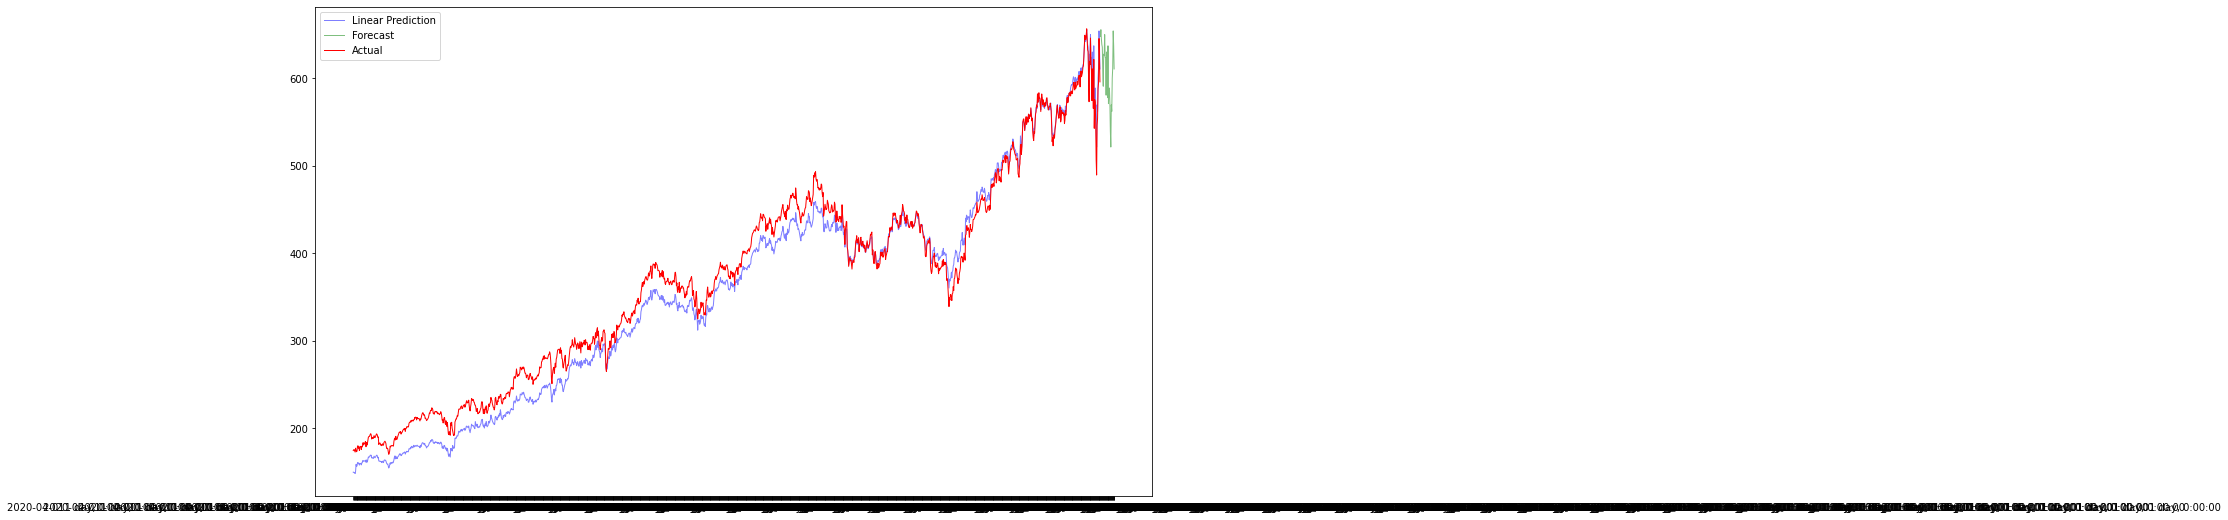

In [ ]:
# Plotting the Actual and Prediction Prices

plt.figure(figsize=(15, 9))
plt.plot(appl.index[display_at:], model_real_prediction[display_at:], label='Linear Prediction', color='blue', alpha=alpha, linewidth=1.0)
plt.plot(predicted_dates, model_predict_prediction, label='Forecast', color='green', alpha=alpha, linewidth=1.0)
plt.plot(appl.index[display_at:], appl['Close'][display_at:], label='Actual', color='red', linewidth=1.0)
plt.legend()

##Muller Loop without any latent variables

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2039, 7)
(2039,)
(510, 7)
(510,)


In [ ]:
type="regressor_WOLV"
muller_loop_regressor(X_train, y_train, X_test, y_test,type)

Model Name:  Decision Tree Regressor
Model Name: Random Forest
Model Name: MLP Regressor
Model Name: AdaBoost Regressor
Model Name: Kernel Ridge


Ill-conditioned matrix (rcond=1.81995e-18): result may not be accurate.


Model Name: GradientBoostingRegressor
Model Name: RandomForestRegressor
Model Name: LinearRegression
Model Name: LGBMRegressor
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


MODEL     R2_SCORE           MSE          MAE      TIME
0    Decision Tree Regressor    98.707664  3.079455e+02    12.433142  0.014918
1              Random Forest    98.978448  2.434216e+02    11.240804  0.061213
2              MLP Regressor -9481.452860  2.283126e+06  1028.717592  0.244363
3         AdaBoost Regressor    98.807850  2.840727e+02    13.109158  0.179406
4               Kernel Ridge    98.419943  3.765053e+02    14.782880  0.311857
5  GradientBoostingRegressor    99.114575  2.109843e+02    10.319046  0.490808
6      RandomForestRegressor    99.240272  1.810325e+02     9.407009  1.056657
7           LinearRegression    98.607018  3.319280e+02    13.501989  0.004788
8              LGBMRegressor    99.185406  1.941062e+02    10.100724  0.313703

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)
Regresssor with better R2 score= RandomForestRegressor, Score (test, accuracy) = 99.24


#Regressor model without Latent Variable execution using pickle file

In [ ]:
regressor=load('/content/drive/MyDrive/MLSpring-2021/MLSpring-2021/teams/musketeers/Midterm/PickleModel/regressor_WOLV_RandomForestRegressor')
regressor.predict(X_test)

array([249.44330109, 250.12230118, 247.88030075, 251.2564006 ,
        67.34369987, 211.47510025, 256.71440155, 249.44330109,
       247.37920135, 249.48970047,  77.49369938, 265.74559875,
       250.77230072, 222.87929932, 246.50640137, 253.58440048,
       250.77230072, 258.26570221, 252.53330048, 268.23829926,
       257.84720016, 164.37850014, 248.01309967, 271.09639832,
        77.53059952, 248.56550003, 197.84849907,  77.60429878,
        75.68839954, 161.04080002, 248.87120117, 249.88749847,
       206.68670166, 222.42479874,  76.96159924, 247.33730072,
       194.91800026, 187.87680038, 253.58440048,  77.6926989 ,
       251.24710068, 250.77230072, 182.69229965, 263.33369644,
       255.50760208,  76.32349941, 240.62560028,  76.75619957,
       245.59900009, 252.53330048, 250.77230072,  77.26439949,
        75.5821994 , 160.39740005, 161.62540077,  75.19809982,
       250.77230072, 249.79739838, 253.01740036,  76.97189957,
        76.39789932, 250.77230072, 244.25070114,  77.07

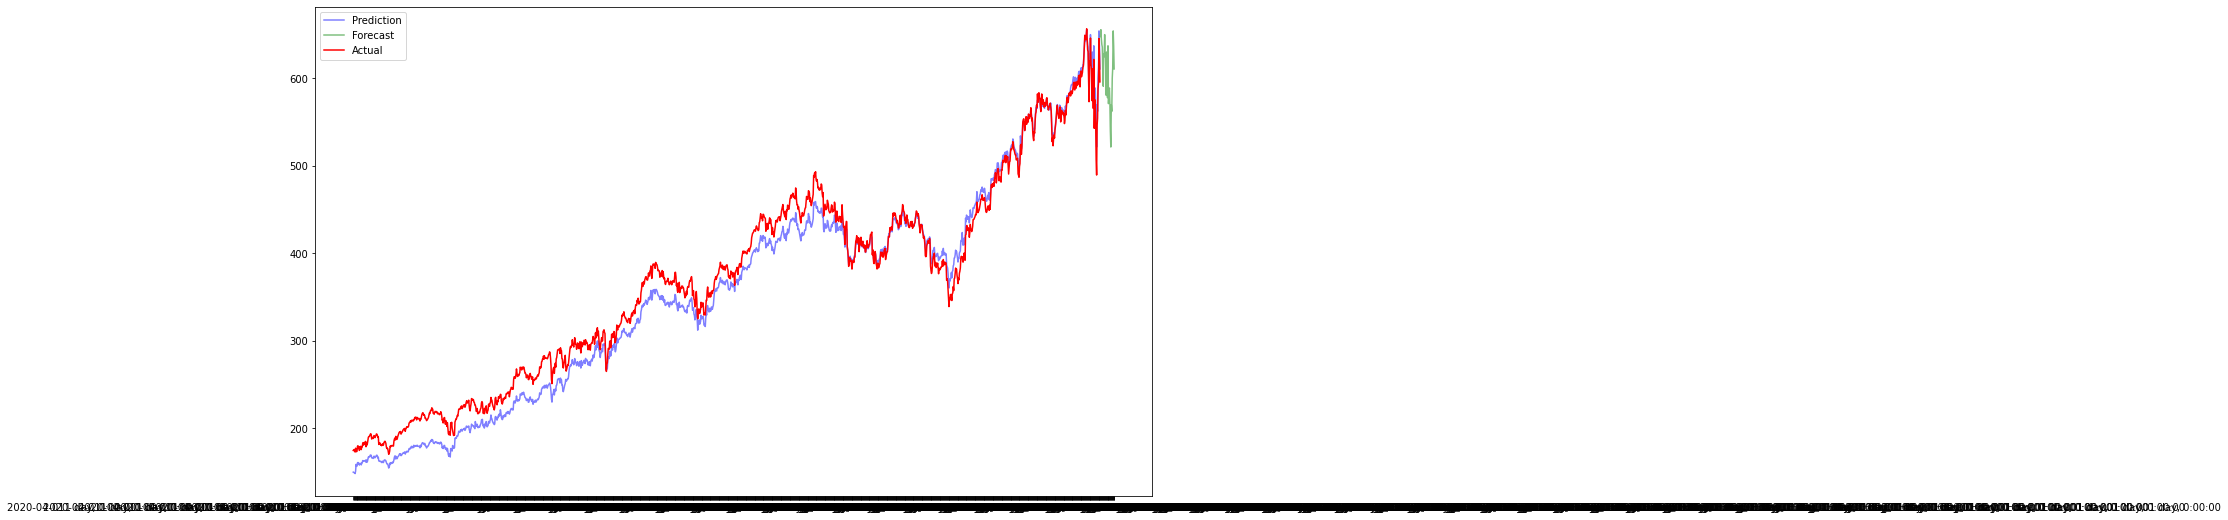

In [ ]:
# Plotting the Actual and Prediction Prices

plt.figure(figsize=(15, 9))
plt.plot(appl.index[display_at:], model_real_prediction[display_at:], label='Prediction', color='blue', alpha=alpha)
plt.plot(predicted_dates, model_predict_prediction, label='Forecast', color='green', alpha=alpha)
plt.plot(appl.index[display_at:], appl['Close'][display_at:], label='Actual', color='red')
plt.legend()

##AutoGluon

In [ ]:
label = 'Prediction'
print("Summary of class variable: \n", appl[label].describe())

Summary of class variable: 
 count    2549.000000
mean      257.001817
std       151.443716
min        58.191978
25%       138.762283
50%       200.462326
75%       383.765717
max       653.284241
Name: Prediction, dtype: float64


In [ ]:
save_path = './agModels-predictClass'

In [ ]:
predictor = TabularPredictor(label=label, path=save_path).fit(appl)

Beginning AutoGluon training ...
AutoGluon will save models to "./agModels-predictClass/"
AutoGluon Version:  0.1.1b20210323
Train Data Rows:    2579
Train Data Columns: 7
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (653.2842407226562, 58.191978454589844, 257.00182, 151.44372)
	If 'regression' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11971.93 MB
	Train Data (Original)  Memory Usage: 0.14 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		

[1000]	train_set's rmse: 12.5707	valid_set's rmse: 14.0389
[2000]	train_set's rmse: 11.5661	valid_set's rmse: 13.6958


	-13.5895	 = Validation root_mean_squared_error score
	1.71s	 = Training runtime
	0.12s	 = Validation runtime
Fitting model: CatBoost ...
	-13.5453	 = Validation root_mean_squared_error score
	3.94s	 = Training runtime
	0.0s	 = Validation runtime
Fitting model: XGBoost ...
	-13.3954	 = Validation root_mean_squared_error score
	1.16s	 = Training runtime
	0.01s	 = Validation runtime
Fitting model: NeuralNetMXNet ...
	-15.2959	 = Validation root_mean_squared_error score
	26.39s	 = Training runtime
	0.36s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
defusedxml.cElementTree is deprecated, import from defusedxml.ElementTree instead.


	-55.8368	 = Validation root_mean_squared_error score
	13.59s	 = Training runtime
	0.14s	 = Validation runtime
Fitting model: LightGBMLarge ...
	-14.3802	 = Validation root_mean_squared_error score
	1.31s	 = Training runtime
	0.01s	 = Validation runtime


Fitting model: WeightedEnsemble_L2 ...
	-12.7083	 = Validation root_mean_squared_error score
	0.46s	 = Training runtime
	0.01s	 = Validation runtime
AutoGluon training complete, total runtime = 56.51s ...
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("./agModels-predictClass/")


In [ ]:
appl.dropna()

Open        High         Low  ...     Volume  Year  Prediction
Date                                            ...                             
2010-01-04  106.519997  109.620003  106.510002  ...   576300.0  2010   79.569298
2010-01-05  109.589996  109.589996  108.379997  ...   681900.0  2010   78.617905
2010-01-06  108.949997  110.570000  108.220001  ...  1397500.0  2010   78.601364
2010-01-07  109.250000  110.349998  106.639999  ...   797200.0  2010   78.187714
2010-01-08  106.800003  107.279999  105.900002  ...   432400.0  2010   77.128777
...                ...         ...         ...  ...        ...   ...         ...
2020-02-12  616.229980  624.580017  612.330017  ...   566400.0  2020  587.580017
2020-02-13  615.099976  636.429993  611.989990  ...   508300.0  2020  594.270020
2020-02-14  639.090027  654.320007  637.190002  ...   438600.0  2020  644.869995
2020-02-18  644.169983  649.989990  639.349976  ...   427900.0  2020  624.570007
2020-02-19  648.190002  650.109985  641.400024  ...   405000.0  2020  595.460022

[2549 rows x 8 columns]

In [ ]:
test_data = appl

In [ ]:
test_data.isnull()

Open   High    Low  Close  Adj Close  Volume   Year  Prediction
Date                                                                        
2010-01-04  False  False  False  False      False   False  False       False
2010-01-05  False  False  False  False      False   False  False       False
2010-01-06  False  False  False  False      False   False  False       False
2010-01-07  False  False  False  False      False   False  False       False
2010-01-08  False  False  False  False      False   False  False       False
...           ...    ...    ...    ...        ...     ...    ...         ...
2020-03-26  False  False  False  False      False   False  False        True
2020-03-27  False  False  False  False      False   False  False        True
2020-03-30  False  False  False  False      False   False  False        True
2020-03-31  False  False  False  False      False   False  False        True
2020-04-01  False  False  False  False      False   False  False        True

[2579 rows x 8 columns]

In [ ]:
test_data = test_data.dropna()

In [ ]:
y_test = test_data[label]  # values to predict
test_data_nolab1 = test_data.drop(columns=[label])  # delete label column to prove we're not cheating
test_data_nolab1.head()

Open        High         Low  ...  Adj Close     Volume  Year
Date                                            ...                            
2010-01-04  106.519997  109.620003  106.510002  ...  90.638535   576300.0  2010
2010-01-05  109.589996  109.589996  108.379997  ...  89.794678   681900.0  2010
2010-01-06  108.949997  110.570000  108.220001  ...  90.613678  1397500.0  2010
2010-01-07  109.250000  110.349998  106.639999  ...  88.760551   797200.0  2010
2010-01-08  106.800003  107.279999  105.900002  ...  88.330353   432400.0  2010

[5 rows x 7 columns]

In [ ]:
test_data_nolab1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2549 entries, 2010-01-04 to 2020-02-19
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2549 non-null   float64
 1   High       2549 non-null   float64
 2   Low        2549 non-null   float64
 3   Close      2549 non-null   float64
 4   Adj Close  2549 non-null   float64
 5   Volume     2549 non-null   float64
 6   Year       2549 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 159.3+ KB


In [ ]:
predictor = TabularPredictor.load(save_path) 

y_pred = predictor.predict(test_data_nolab1)
print("Predictions:  \n", y_pred)
perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)

Evaluation: root_mean_squared_error on test data: 6.760474990282783
Evaluations on test data:
{
    "root_mean_squared_error": 6.760474990282783,
    "mean_absolute_error": 4.3158287865454295,
    "explained_variance_score": 0.9980064848793168,
    "r2_score": 0.9980064721063479,
    "pearson_correlation": 0.9990051994091936,
    "mean_squared_error": 45.70402209423901,
    "median_absolute_error": 2.845367431640625
}


Predictions:  
 Date
2010-01-04     80.085289
2010-01-05     80.270409
2010-01-06     78.872993
2010-01-07     79.066429
2010-01-08     80.047920
                 ...    
2020-02-12    589.807739
2020-02-13    595.842896
2020-02-14    634.052917
2020-02-18    619.611633
2020-02-19    598.748657
Name: Prediction, Length: 2549, dtype: float32


##Muller Loop with Latent Variables

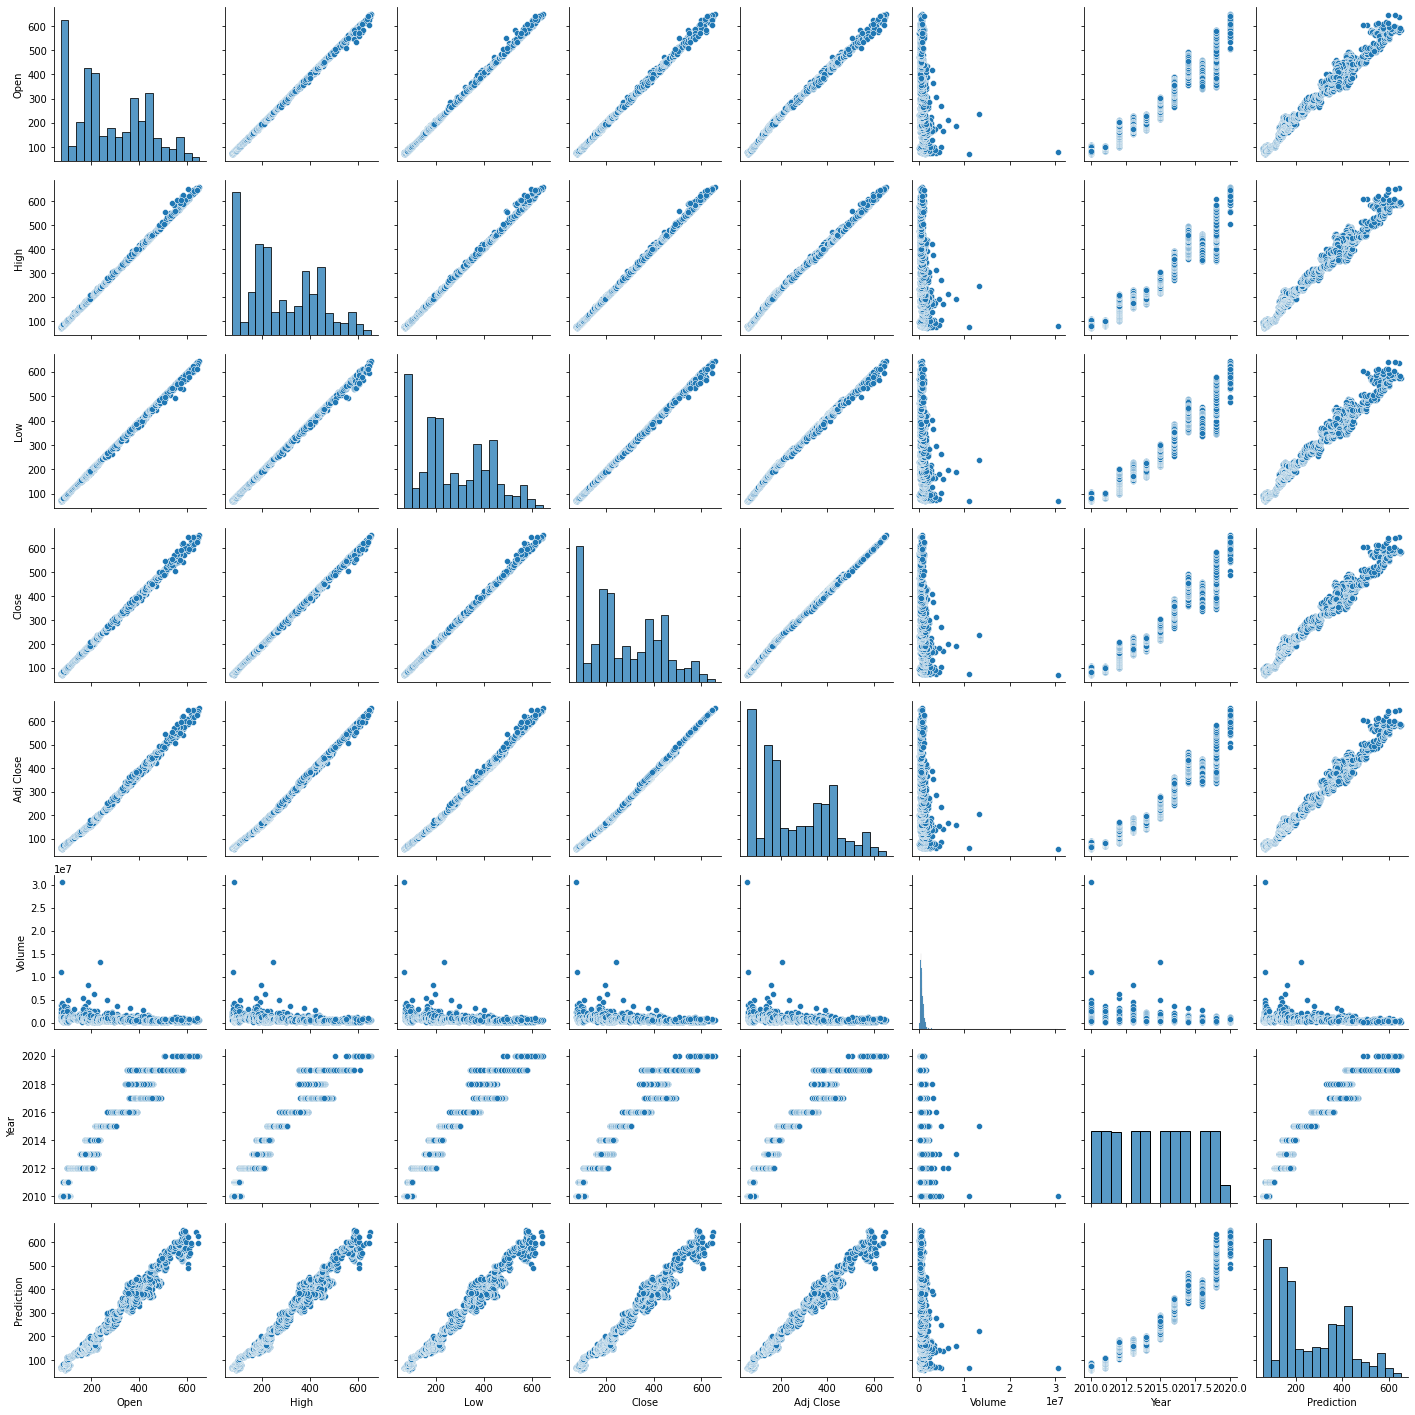

In [ ]:
# Data distribution plots by every feature by feature
sns.pairplot(appl)

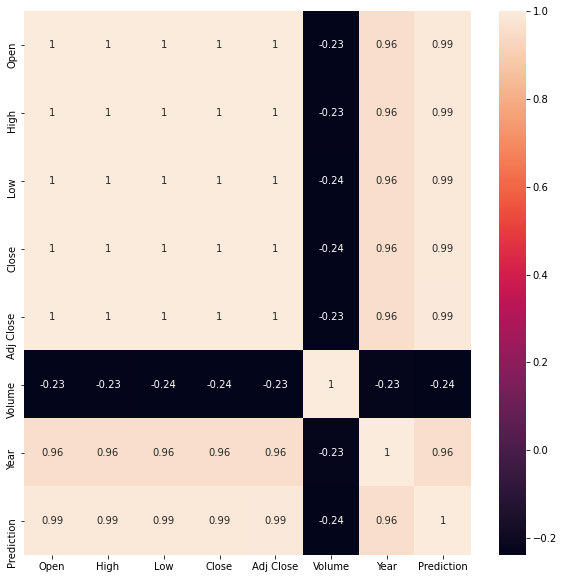

In [ ]:
corr = appl.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5053096 entries, 0 to 24165053
Data columns (total 9 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Date       object 
 1   Open       float64
 2   High       float64
 3   Low        float64
 4   Close      float64
 5   Adj Close  float64
 6   Volume     float64
 7   Ticker     object 
 8   Year       int64  
dtypes: float64(6), int64(1), object(2)
memory usage: 385.5+ MB


In [ ]:
anet = df[df.Ticker.isin(["EQIX"])]

Boolean Series key will be reindexed to match DataFrame index.


In [ ]:
anet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1573 entries, 7446758 to 7448330
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1573 non-null   object 
 1   Open       1573 non-null   float64
 2   High       1573 non-null   float64
 3   Low        1573 non-null   float64
 4   Close      1573 non-null   float64
 5   Adj Close  1573 non-null   float64
 6   Volume     1573 non-null   float64
 7   Ticker     1573 non-null   object 
 8   Year       1573 non-null   int64  
dtypes: float64(6), int64(1), object(2)
memory usage: 122.9+ KB


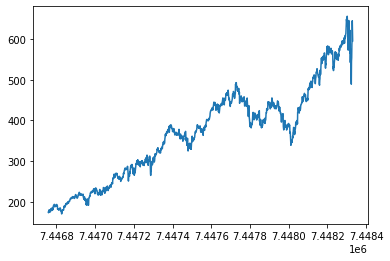

In [ ]:
anet['Close'].plot()

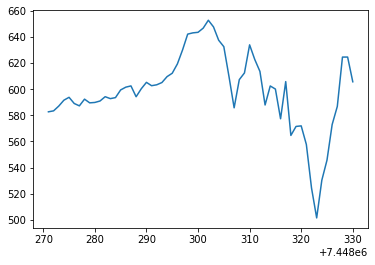

In [ ]:
"""
Next we clean our data and perform feature engineering to create new technical indicator features that our
model can learn from
"""

def _exponential_smooth(data, alpha):
    """
    Function that exponentially smooths dataset so values are less 'rigid'
    :param alpha: weight factor to weight recent values more
    """
    
    return data.ewm(alpha=alpha).mean()

anet = _exponential_smooth(anet, 0.65)

anet.head()

tmp1 = anet.iloc[-60:]
tmp1['Close'].plot()

In [ ]:
# List of symbols for technical indicators
INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'EMV', 'VORTEX']

In [ ]:
def _get_indicator_data(data):
    """
    Function that uses the finta API to calculate technical indicators used as the features
    :return:
    """

    for indicator in INDICATORS:
        ind_data = eval('TA.' + indicator + '(data)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        data = data.merge(ind_data, left_index=True, right_index=True)
    data.rename(columns={"14 period EMV.": '14 period EMV'}, inplace=True)

    # Also calculate moving averages for features
    data['ema50'] = data['Close'] / data['Close'].ewm(50).mean()
    data['ema21'] = data['Close'] / data['Close'].ewm(21).mean()
    data['ema15'] = data['Close'] / data['Close'].ewm(14).mean()
    data['ema5'] = data['Close'] / data['Close'].ewm(5).mean()

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    data['normVol'] = data['Volume'] / data['Volume'].ewm(5).mean()

    # Remove columns that won't be used as features
    del (data['Open'])
    del (data['High'])
    del (data['Low'])
    del (data['Volume'])
    #del (data['Adj Close'])
    
    return data

anet = _get_indicator_data(anet)
print(anet.columns)

Index(['Close', 'Adj Close', 'Year', '14 period RSI', 'MACD', 'SIGNAL',
       '14 period STOCH %K', 'MFV', '14 period ATR', 'MOM', '14 period MFI',
       'ROC', 'OBV', '20 period CCI', '14 period EMV', 'VIm', 'VIp', 'ema50',
       'ema21', 'ema15', 'ema5', 'normVol'],
      dtype='object')


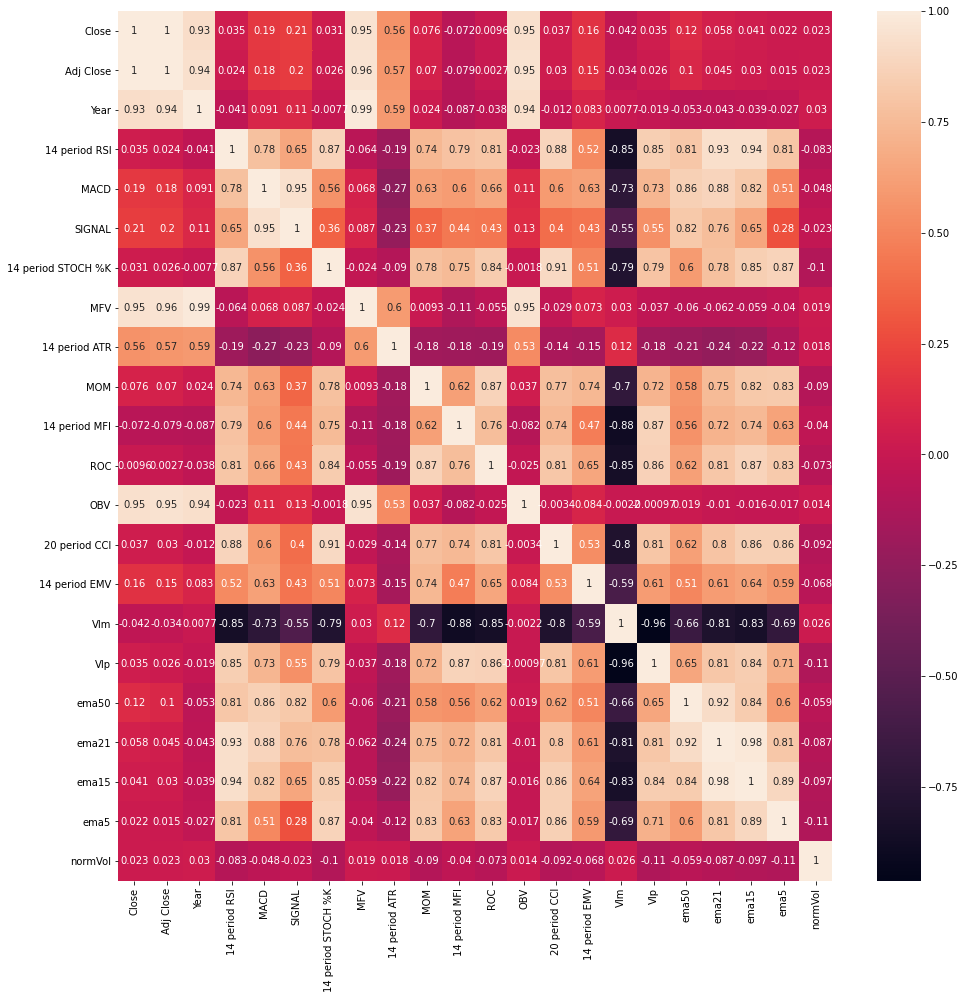

In [ ]:
corr = anet.corr()
plt.figure(figsize=(16, 16))
sns.heatmap(corr, annot=True)

In [ ]:
anet['Prediction'] = anet['Adj Close'].shift(-predict_days)
print(anet['Prediction'])
print(anet['Adj Close'])

7446758    159.320867
7446759    160.095060
7446760    159.613155
7446761    156.933227
7446762    156.791119
              ...    
7448326           NaN
7448327           NaN
7448328           NaN
7448329           NaN
7448330           NaN
Name: Prediction, Length: 1573, dtype: float64
7446758    144.578186
7446759    143.757026
7446760    143.988820
7446761    147.014596
7446762    148.411987
              ...    
7448326    572.911625
7448327    586.794581
7448328    624.543600
7448329    624.560765
7448330    605.645282
Name: Adj Close, Length: 1573, dtype: float64


In [ ]:
anet = anet.dropna()
X = np.array(anet.drop(['Prediction'], axis = 1))
X = X[:-predict_days]      # Size upto predict days
print(X)
print(X.shape)

[[1.812994e+02 1.499883e+02 2.014000e+03 6.760747e+01 ... 1.018943e+00 1.018184e+00 1.014927e+00 1.817728e+00]
 [1.829768e+02 1.513759e+02 2.014000e+03 7.151612e+01 ... 1.025850e+00 1.024783e+00 1.019947e+00 1.664399e+00]
 [1.817374e+02 1.503505e+02 2.014000e+03 6.525079e+01 ... 1.017302e+00 1.016091e+00 1.010738e+00 1.170227e+00]
 [1.822981e+02 1.508144e+02 2.014000e+03 6.667322e+01 ... 1.018772e+00 1.017393e+00 1.011430e+00 8.092457e-01]
 ...
 [5.825422e+02 5.801395e+02 2.019000e+03 6.930535e+01 ... 1.034808e+00 1.029993e+00 1.015789e+00 8.616038e-01]
 [5.804673e+02 5.780731e+02 2.019650e+03 6.608834e+01 ... 1.029666e+00 1.024526e+00 1.010122e+00 1.180727e+00]
 [5.834915e+02 5.810849e+02 2.019878e+03 6.839131e+01 ... 1.033385e+00 1.027818e+00 1.012788e+00 1.143823e+00]
 [5.841340e+02 5.817247e+02 2.019957e+03 6.887490e+01 ... 1.032902e+00 1.026967e+00 1.011559e+00 9.563902e-01]]
(1499, 22)


In [ ]:
y = np.array(anet['Prediction'])
y = y[:-predict_days]      # Size upto predict_days
# print(y)
print(y.shape)

(1499,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)      #Splitting the data into 80% for training & 20% for testing
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1199, 22)
(1199,)
(300, 22)
(300,)


In [ ]:
linear_model1 = LinearRegression()
linear_model1.fit(X_train, y_train)   

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
linear_model_score1 = linear_model1.score(X_test, y_test)
print('Linear Model score:', linear_model_score1)

Linear Model score: 0.9715603774112871


In [ ]:
# Define the Real & Prediction Values
X_predict1 = np.array(anet.drop(['Prediction'], 1))[-predict_days:]

linear_model_predict_prediction1 = linear_model1.predict(X_predict1)
linear_model_real_prediction1 = linear_model1.predict(np.array(anet.drop(['Prediction'], 1)))

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1199, 22)
(1199,)
(300, 22)
(300,)


In [ ]:
type="regressor_WLV"
muller_loop_regressor(X_train, y_train, X_test, y_test,type)

Model Name:  Decision Tree Regressor
Model Name: Random Forest
Model Name: MLP Regressor
Model Name: AdaBoost Regressor
Model Name: Kernel Ridge


Singular matrix in solving dual problem. Using least-squares solution instead.


Model Name: GradientBoostingRegressor
Model Name: RandomForestRegressor
Model Name: LinearRegression
Model Name: LGBMRegressor
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


MODEL      R2_SCORE  ...           MAE      TIME
0    Decision Tree Regressor  9.869550e+01  ...      9.601428  0.025376
1              Random Forest  9.893079e+01  ...      8.643195  0.103708
2              MLP Regressor -9.958242e+06  ...  29327.198278  1.037799
3         AdaBoost Regressor  9.813102e+01  ...     12.580104  0.213513
4               Kernel Ridge  8.765987e+01  ...     32.593965  0.734470
5  GradientBoostingRegressor  9.953898e+01  ...      5.757334  0.858464
6      RandomForestRegressor  9.979228e+01  ...      3.729894  1.504092
7           LinearRegression  9.715604e+01  ...     16.224315  0.005440
8              LGBMRegressor  9.980027e+01  ...      3.960866  0.385139

[9 rows x 5 columns]

LGBMRegressor(bagging_fraction=0.8, boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, feature_fraction=0.8,
              importance_type='split', learning_rate=0.17, max_depth=-1,
              metric='rmse', min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=1200,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.9, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)
Regresssor with better R2 score= LGBMRegressor, Score (test, accuracy) = 99.80


In [ ]:
regressorlv=load('/content/drive/MyDrive/MLSpring-2021/MLSpring-2021/teams/musketeers/Midterm/PickleModel/regressor_WLV_LGBMRegressor')
regressorlv.predict(X_test)

array([236.873237,  74.262437, 251.830915,  68.387451, ..., 223.047831, 267.685504, 269.231672, 264.486128])